# Nested sampling

*Davide Gerosa (Milano-Bicocca)*


This course is based on previous work by many people. See [here]((https://github.com/dgerosa/machinelearning4physics_bicocca_2024) for credits.

---

MCMCs are great and often my go-to option for parameter estimation (easy to setup, easy to understand what's going on, easy to conquer the world).

The crucial limitation is that they don't provide the evidence, which is the key ingredient one needs for model selection.

Let's look at another algorithm that instead does provide the evidence (but it's more complicated...)

# Integrating the evidence with nested sampling

Nested sampling is a very different MCMC method from Metropolis-Hastings or even Gibbs approaches. It's very recent and nonetheless very popular. The [first paper is from 2004 by Skilling](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S).


- One starts with many points spread throughout the prior volume.
- The points are ranked in terms of their likelihood.
- The lowest ranked point is removed, and a higher likelihood point is randomly added.
- This is repeated, until the cluster of points climbs up the likelihood surface, accumulating Bayesian evidence information along the way.

The prior volume is defined as $dX = p(\theta)d^n\theta$ such that $X(\lambda) = \int_{p(d|\theta)>\lambda}p(\theta)d^n\theta$, where the integral is over the model parameter region that exceeds the iso-likelihood contour $p(d|\theta)=L(\theta)=\lambda$.

This transforms the evidence integral into

$$\mathcal{Z} = \int p(d|\theta)p(\theta)d^n\theta = \int_0^1 L(X)dX.$$


Here is how the algorithm works:


![Screen%20Shot%202022-03-30%20at%2008.35.40.png](attachment:Screen%20Shot%202022-03-30%20at%2008.35.40.png)

([credits](https://en.wikipedia.org/wiki/Nested_sampling_algorithm))


The form of the $X_{i}$ is not unique, but it needs to be an estimator of the amount of prior mass in the parameter space of all points with likelihood greater than $L_i$. See [Skilling 2006](https://projecteuclid.org/journals/bayesian-analysis/volume-1/issue-4/Nested-sampling-for-general-Bayesian-computation/10.1214/06-BA127.full) for more.

![Screen%20Shot%202022-03-29%20at%2017.44.04.png](attachment:Screen%20Shot%202022-03-29%20at%2017.44.04.png)


This paper is a nice example from the field of cosmology: https://arxiv.org/abs/astro-ph/0508461




There are several popular packages that perform nested sampling, and not only do they all compute the Bayesian evidence but they also produce posterior samples as a by-product.


By far the most historically well known is [`MultiNest`](https://github.com/rjw57/MultiNest) and its Python wrapper [`PyMultiNest`](https://johannesbuchner.github.io/PyMultiNest/). It used to be (and may still be) a bit of a pain to install though (there is C and Fortran involved). Refs [here](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S/abstract), and [here](https://academic.oup.com/mnras/article/398/4/1601/981502?login=true).


So while this is the big one, there seem to be other more pythonic implementations now on the market. Let's look at one in particular, which is used in my research field.

---

### Dynesty <a class="anchor" id="twoa"></a>

It's as recent as 2019. https://arxiv.org/abs/1904.02180

![](https://github.com/joshspeagle/dynesty/blob/master/docs/images/title.gif?raw=true)

This example comes from the [dynesty](https://arxiv.org/abs/1904.02180) ["crash course"](https://dynesty.readthedocs.io/en/latest/crashcourse.html). We define our likelihood to be a $3$D correlated multivariate Gaussian distribution, and our prior to be uniform in each dimension from $-10$ to $10$.

In [1]:
pip install dynesty

In [2]:
import dynesty
import numpy as np

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)


In [3]:
C

array([[1.  , 0.95, 0.95],
       [0.95, 1.  , 0.95],
       [0.95, 0.95, 1.  ]])

In [4]:
def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm # Notice I need the correct normalization now!

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

Run the sampler.

In [5]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

4723it [00:09, 499.03it/s, +500 | bound: 8 | nc: 1 | ncall: 24031 | eff(%): 22.196 | loglstar:   -inf < -0.297 <    inf | logz: -8.950 +/-  0.128 | dlogz:  0.001 >  0.509]


You've just estimated the Bayesian evidence and posterior. Plot the results. These figures will have an $x$-axis that is $-\ln X$ which is a bit confusing to think about to begin with, but remember that we are moving up the likelihood contours when going from left to right on the graphs.

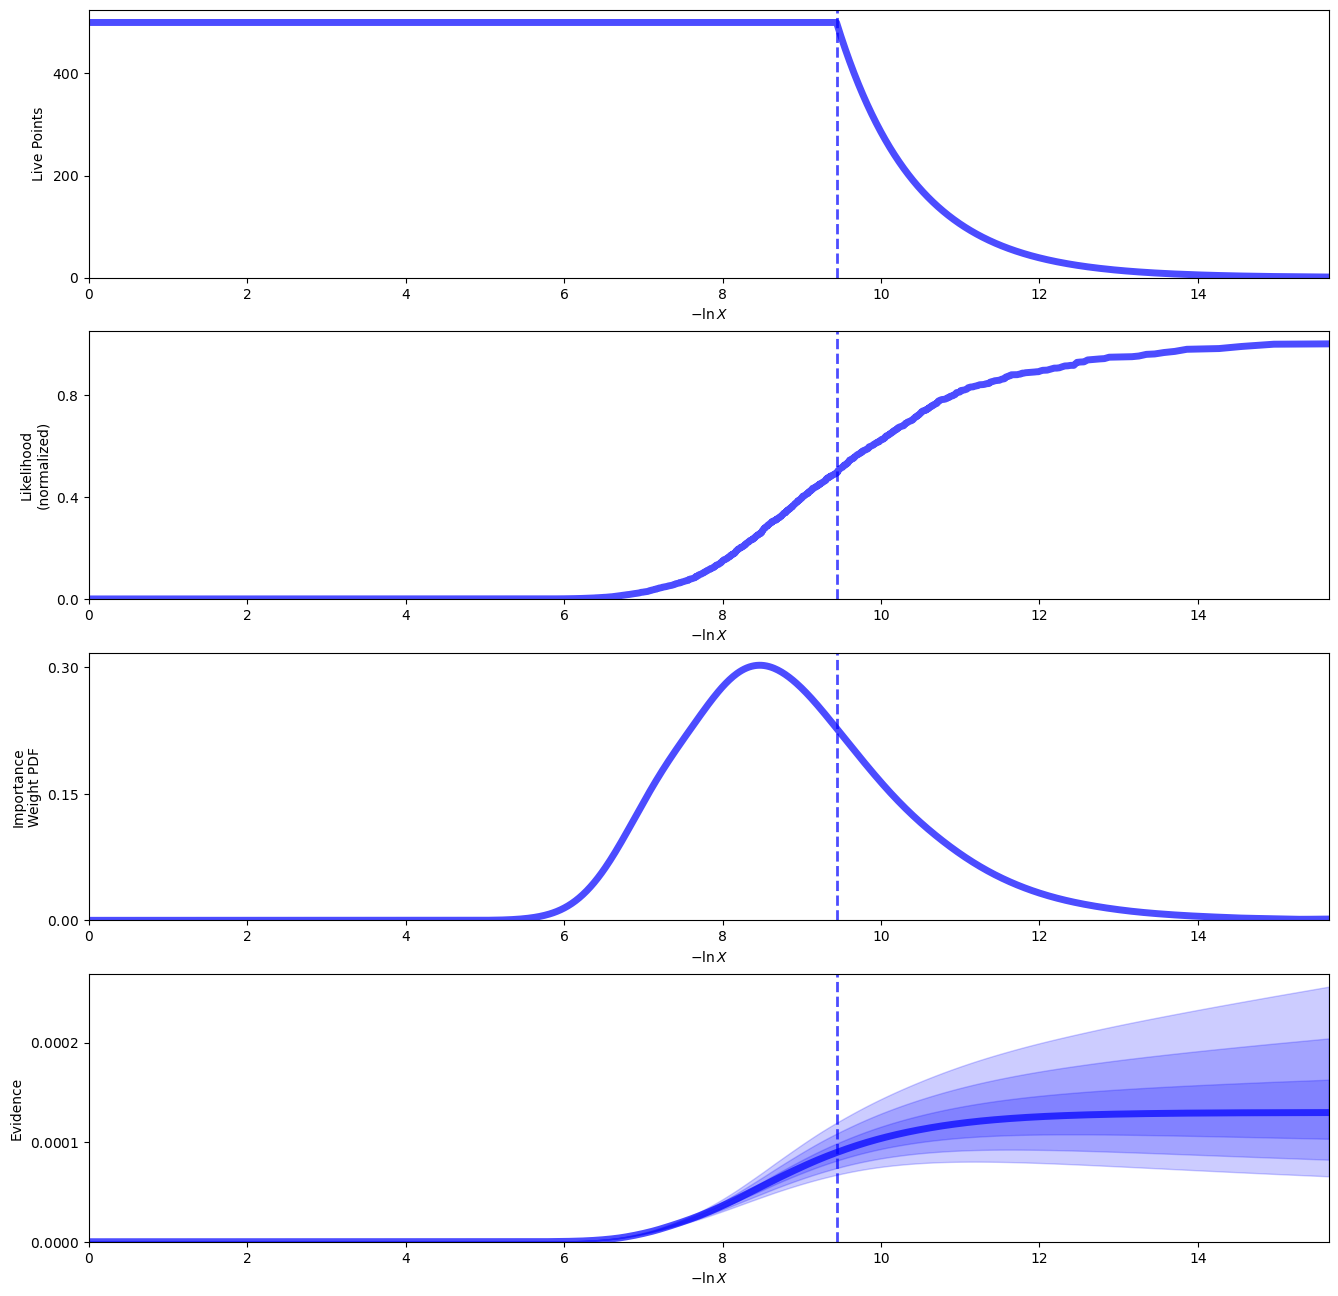

In [6]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

Plot parameter traces and 1-D marginalized posteriors. On the left panels, you'll see that the live points started out scattereed across the prior volume, then move inwards as the sampler climbs the likelihood.

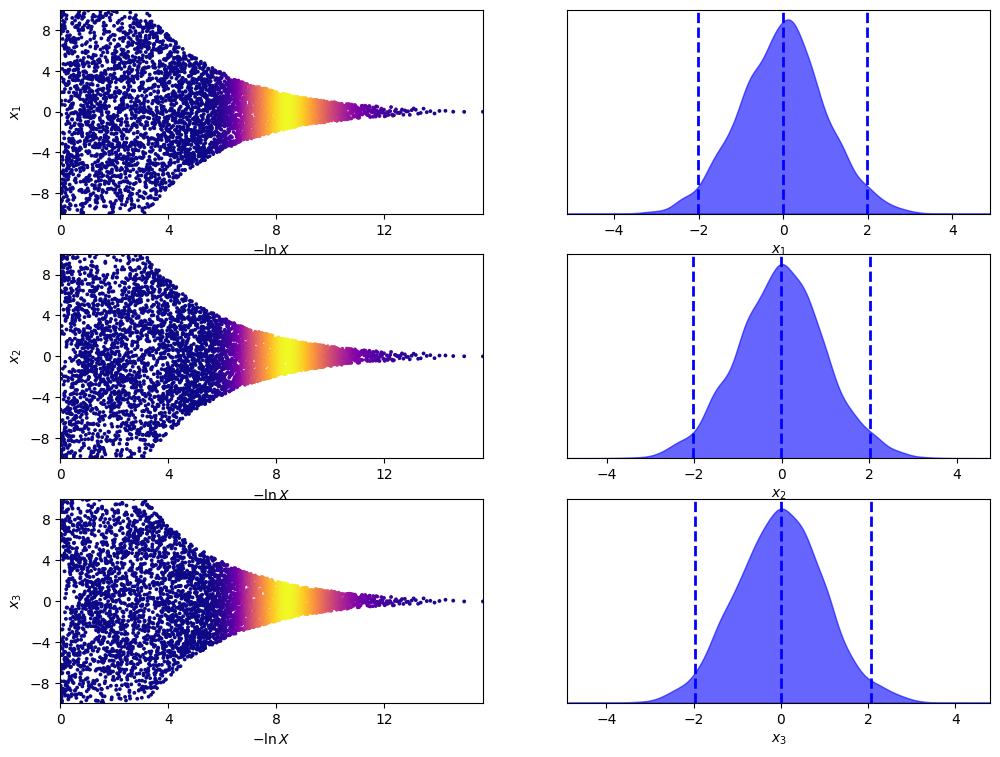

In [7]:
tfig, taxes = dyplot.traceplot(sresults)

Plot the 2-D marginalized posteriors using `dynesty` routines. (But you could also use `corner` if you wish).

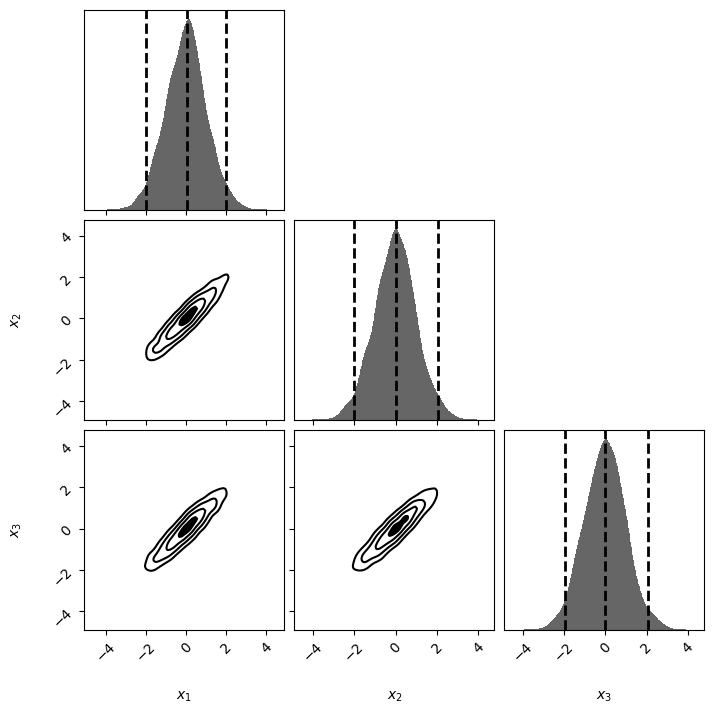

In [8]:
cfig, caxes = dyplot.cornerplot(sresults)

`dynesty` also lets you access many other utilities and analysis outputs. See below.

In [9]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))


# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 0.00012971486398904915
68% parameter credible regions are:
 [[-1.0255988623805568, 0.9636569716216636], [-1.0011238521080372, 0.9564582646840184], [-1.032433969222425, 0.9630391821233059]]

Mean and covariance of parameters are: [-0.01833325 -0.01964064 -0.02139687]
[[1.01932037 0.97276897 0.96900961]
 [0.97276897 1.01951655 0.96850389]
 [0.96900961 0.96850389 1.01632263]]


**Very important** Samples that come out of a nested sampling runs are **weighted**. The results of nested sampling and the samples and their weights *together*. Do not use samples by themselves, it doesn't make sense.

*dynesty* can produce *equally weighted samples*. This is useful if you then want to used them in another package (for instance `corner`) that cannot deal with weights.

In [10]:
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)


In [11]:
pip install corner

In [12]:
import corner
corner.corner(samples_equal);

The code even helpfully tells you what work you should be citing based on the run configurations that you used.

In [13]:
print(sampler.citations)

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S
Koposov et al. (2023): doi.org/10.5281/zenodo.3348367

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944


Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:




There is a lot to explore in the `dynesty` package. It is not a panacea, and there are some things you may have to tune, e.g. the **number of initialized live points**, and **the evidence tolerance**. Dig into these caveats in your own time for your own research problems.

Additionally, it implements **dynamic nested sampling** that dynamically allocates live points to explore higher posterior regions better at the expense of increasing the relative evidence uncertainty. See https://dynesty.readthedocs.io/en/latest/dynamic.html.

In [14]:
## "Dynamic" nested sampling.

#dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
#dsampler.run_nested()
#dresults = dsampler.results

#### Some harder examples...

Have a look at some of these runs!

https://dynesty.readthedocs.io/en/latest/examples.html

###  UltraNest <a class="anchor" id="twob"></a>

*Refs: MLFriends (Buchner, 2014; 2019) using UltraNest https://johannesbuchner.github.io/UltraNest/*

To see how `UltraNest` works compared to standard MCMC algorithms, go [here](https://johannesbuchner.github.io/UltraNest/method.html#visualisation).

You should have seen this kind of visualization before for Metropolis-Hastings, but this helps make it clear how the new live points are being chosen from within the prior volume, and how the whole set of points are moving up the likelihood surface.

We'll look at an example from [UltraNest's documentation](https://johannesbuchner.github.io/UltraNest/using-ultranest.html). This involves fitting a **spectral line feature**. There are many other tutorials on the documentation to dig into in your own time.

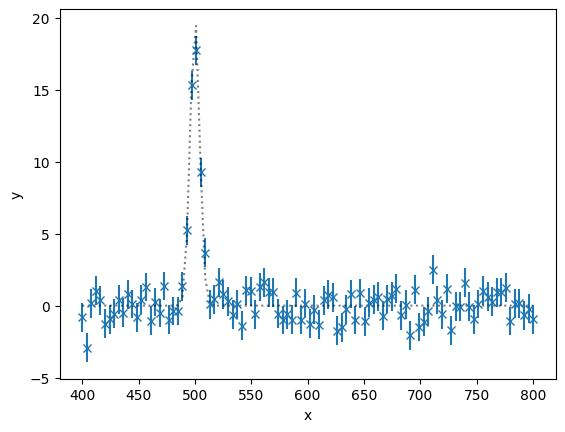

In [15]:
import pylab as plt

# Generate data over a wavelength range with a noisy signal
x = np.linspace(400, 800, 100)
yerr = 1.0
y = np.random.normal(20 * np.exp(-0.5 * ((x-500)/4.2)**2), yerr)

plt.errorbar(x, y, yerr=yerr, ls=' ', marker='x')
plt.plot(x, 20 * np.exp(-0.5 * ((x-500)/4.2)**2), ls=':', alpha=0.5, color='k')
plt.xlabel('x')
plt.ylabel('y');

This problem has 3 parameters: The location, amplitude and width of the gaussian line. We assume that the noise level is known.

In [16]:
param_names = ['location', 'amplitude', 'width']

As in `dynesty`, the parameter space is defined through a transform from unit values ($0,\ldots,1$) to the physical range.

The next function demonstrates:
- a uniform prior for a location parameter
- a log-uniform prior for a scale parameter
- a log-normal prior

In [17]:
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 400
    hi = 800
    params[0] = cube[0] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = 0.1
    hi = 100
    params[1] = 10**(cube[1] * (np.log10(hi) - np.log10(lo)) + np.log10(lo))

    # More complex prior, you can use the ppf functions
    # from scipy.stats, such as scipy.stats.norm(mean, std).ppf

    # transform for width:
    # a log-normal centered at 1 +- 1dex
    params[2] = 10**stats.norm.ppf(cube[2], 0, 1)

    return params

Next, we need to specify the data likelihood given certain parameters:

In [18]:
def my_likelihood(params):
    location, amplitude, width = params
    # compute intensity at every x position according to the model
    y_model = amplitude * np.exp(-0.5 * ((x - location)/width)**2)
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - y)/yerr)**2).sum()
    return like

Ready to sample!

In [19]:
pip install ultranest

In [20]:
import ultranest
from scipy import stats

sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood,
                                          my_prior_transform)

DEBUG:ultranest:ReactiveNestedSampler: dims=3+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


Take a second to install ipython widgets for some interactive run updates.

In [21]:
pip install ipywidgets

In [22]:
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]




Mono-modal Volume: ~exp(-4.42) * Expected Volume: exp(0.00) Quality: ok

location :  +4.0e+02|************************************************| +8.0e+02
amplitude:      +0.1|********************************** ****** **** *|   +100.0
width    :  +1.8e-05|******  * *         *         *         *       | +1.0e+03



DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-34777.65, Lmax=-190.12


DEBUG:ultranest:iteration=19, ncalls=421, regioncalls=840, ndraw=40, logz=-4347.35, remainder_fraction=100.0000%, Lmin=-4254.46, Lmax=-190.12


DEBUG:ultranest:iteration=40, ncalls=442, regioncalls=1680, ndraw=40, logz=-1359.87, remainder_fraction=100.0000%, Lmin=-1338.48, Lmax=-190.12


DEBUG:ultranest:iteration=57, ncalls=463, regioncalls=2520, ndraw=40, logz=-747.22, remainder_fraction=100.0000%, Lmin=-731.37, Lmax=-190.12


DEBUG:ultranest:iteration=80, ncalls=489, regioncalls=3560, ndraw=40, logz=-540.04, remainder_fraction=100.0000%, Lmin=-522.25, Lmax=-190.12




Mono-modal Volume: ~exp(-4.42)   Expected Volume: exp(-0.23) Quality: ok

location :  +4.0e+02|************************************************| +8.0e+02
amplitude:      +0.1|************* * *******  *** * **  * *  *  * *  |   +100.0
width    :  +1.8e-05|******  **  *       *         *         *       | +1.0e+03



DEBUG:ultranest:iteration=90, ncalls=499, regioncalls=3960, ndraw=40, logz=-487.12, remainder_fraction=100.0000%, Lmin=-478.01, Lmax=-190.12


DEBUG:ultranest:iteration=111, ncalls=525, regioncalls=5000, ndraw=40, logz=-423.46, remainder_fraction=100.0000%, Lmin=-416.35, Lmax=-190.12


DEBUG:ultranest:iteration=120, ncalls=535, regioncalls=5400, ndraw=40, logz=-412.30, remainder_fraction=100.0000%, Lmin=-405.75, Lmax=-190.12


DEBUG:ultranest:iteration=159, ncalls=584, regioncalls=7360, ndraw=40, logz=-391.73, remainder_fraction=100.0000%, Lmin=-386.91, Lmax=-128.70


DEBUG:ultranest:iteration=160, ncalls=585, regioncalls=7400, ndraw=40, logz=-391.54, remainder_fraction=100.0000%, Lmin=-386.83, Lmax=-128.70




Mono-modal Volume: ~exp(-4.65) * Expected Volume: exp(-0.45) Quality: ok

location :  +4.0e+02|************************************************| +8.0e+02
amplitude:      +0.1|*************** ******* ********** * ** *  * *  |   +100.0
width    :  +1.8e-05|**** *  *           *         *         *       | +1.0e+03



DEBUG:ultranest:iteration=180, ncalls=615, regioncalls=8600, ndraw=40, logz=-388.58, remainder_fraction=100.0000%, Lmin=-384.37, Lmax=-128.70


DEBUG:ultranest:iteration=193, ncalls=631, regioncalls=9240, ndraw=40, logz=-387.55, remainder_fraction=100.0000%, Lmin=-383.87, Lmax=-128.70


DEBUG:ultranest:iteration=200, ncalls=642, regioncalls=9680, ndraw=40, logz=-387.15, remainder_fraction=100.0000%, Lmin=-383.56, Lmax=-128.70


DEBUG:ultranest:iteration=221, ncalls=674, regioncalls=10960, ndraw=40, logz=-386.25, remainder_fraction=100.0000%, Lmin=-383.10, Lmax=-128.70


DEBUG:ultranest:iteration=240, ncalls=703, regioncalls=12120, ndraw=40, logz=-385.72, remainder_fraction=100.0000%, Lmin=-382.89, Lmax=-128.70




Mono-modal Volume: ~exp(-4.65)   Expected Volume: exp(-0.67) Quality: ok

location :  +4.0e+02|************************************************| +8.0e+02
amplitude:      +0.1|*************** ******* ********** * ****  ***  |   +100.0
width    :  +1.8e-05|****    *     *     *         *         *       | +1.0e+03



DEBUG:ultranest:iteration=270, ncalls=748, regioncalls=13920, ndraw=40, logz=-385.17, remainder_fraction=100.0000%, Lmin=-382.70, Lmax=-128.70


DEBUG:ultranest:iteration=280, ncalls=764, regioncalls=14560, ndraw=40, logz=-385.03, remainder_fraction=100.0000%, Lmin=-382.66, Lmax=-128.70


DEBUG:ultranest:iteration=315, ncalls=818, regioncalls=16720, ndraw=40, logz=-384.65, remainder_fraction=100.0000%, Lmin=-382.59, Lmax=-128.70


DEBUG:ultranest:iteration=320, ncalls=827, regioncalls=17080, ndraw=40, logz=-384.61, remainder_fraction=100.0000%, Lmin=-382.59, Lmax=-128.70
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.




Mono-modal Volume: ~exp(-4.38) * Expected Volume: exp(-0.88) Quality: ok

location :  +4.0e+02|************************************************| +8.0e+02
amplitude:      +0.1|*************** ******* ********** * ****  ***  |   +100.0
width    :  +1.8e-05|*****  **     *     *         *         *       | +1.0e+03



DEBUG:ultranest:iteration=353, ncalls=880, regioncalls=19200, ndraw=40, logz=-384.37, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.




Mono-modal Volume: ~exp(-4.50) * Expected Volume: exp(-0.89) Quality: ok

location :  +4.0e+02|************************************************| +8.0e+02
amplitude:      +0.1|*************** ****************** * ****  ***  |   +100.0
width    :  +1.8e-05|*****  **     *     *         *         *       | +1.0e+03



DEBUG:ultranest:iteration=355, ncalls=885, regioncalls=19400, ndraw=40, logz=-384.36, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing 



Mono-modal Volume: ~exp(-4.21) * Expected Volume: exp(-1.48) Quality: ok

location :  +4.0e+02|  ********************** ** ******** ** ******* | +8.0e+02
amplitude:      +0.1|***************   *   **    * **     *  *  ***  |   +100.0
width    :  +1.8e-05|*****  **     *     *         *         *       | +1.0e+03



DEBUG:ultranest:iteration=533, ncalls=886, regioncalls=19440, ndraw=40, logz=-383.62, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70
DEBUG:ultranest:Plateau detected at L=-3.825840e+02, not replacing live point.




Mono-modal Volume: ~exp(-3.84) * Expected Volume: exp(-1.49) Quality: ok

location :  +4.0e+02|  ********************** ** ******** ** ******* | +8.0e+02
amplitude:      +0.1|***************   *   **    * **     *     ***  |   +100.0
width    :  +1.8e-05|*****  **     *     *         *         *       | +1.0e+03



DEBUG:ultranest:iteration=535, ncalls=887, regioncalls=19480, ndraw=40, logz=-383.62, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70


DEBUG:ultranest:iteration=545, ncalls=927, regioncalls=21080, ndraw=40, logz=-383.59, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70


DEBUG:ultranest:iteration=560, ncalls=1000, regioncalls=24000, ndraw=40, logz=-383.55, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70


DEBUG:ultranest:iteration=575, ncalls=1060, regioncalls=26400, ndraw=40, logz=-383.52, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70


DEBUG:ultranest:iteration=583, ncalls=1126, regioncalls=29040, ndraw=40, logz=-383.50, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70




Mono-modal Volume: ~exp(-3.84)   Expected Volume: exp(-1.71) Quality: ok

location :  +4.0e+02|  ********************* *** ****** * ** * ***** | +8.0e+02
amplitude:      +0.1|********* ** *        **      *      *        * |   +100.0
width    :  +1.8e-05|*****  **     *     *         *    *   **       | +1.0e+03



DEBUG:ultranest:iteration=585, ncalls=1131, regioncalls=29240, ndraw=40, logz=-383.50, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70


DEBUG:ultranest:iteration=591, ncalls=1163, regioncalls=30520, ndraw=40, logz=-383.48, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70


DEBUG:ultranest:iteration=600, ncalls=1200, regioncalls=32000, ndraw=40, logz=-383.47, remainder_fraction=100.0000%, Lmin=-382.58, Lmax=-128.70


DEBUG:ultranest:iteration=608, ncalls=1243, regioncalls=33720, ndraw=40, logz=-383.45, remainder_fraction=100.0000%, Lmin=-382.57, Lmax=-128.70


DEBUG:ultranest:iteration=618, ncalls=1296, regioncalls=35840, ndraw=40, logz=-383.44, remainder_fraction=100.0000%, Lmin=-382.56, Lmax=-128.70




Mono-modal Volume: ~exp(-3.84)   Expected Volume: exp(-1.94) Quality: ok

location :  +4.0e+02| ********************** ****** ***   ** ******  | +8.0e+02
amplitude:      +0.1|********* ** *        **             *        * |   +100.0
width    :  +1.8e-05|*********     *     *        **   **   **       | +1.0e+03



DEBUG:ultranest:iteration=635, ncalls=1379, regioncalls=39160, ndraw=40, logz=-383.41, remainder_fraction=100.0000%, Lmin=-382.54, Lmax=-128.70


DEBUG:ultranest:iteration=640, ncalls=1407, regioncalls=40280, ndraw=40, logz=-383.40, remainder_fraction=100.0000%, Lmin=-382.53, Lmax=-128.70


DEBUG:ultranest:iteration=653, ncalls=1487, regioncalls=43480, ndraw=40, logz=-383.38, remainder_fraction=100.0000%, Lmin=-382.50, Lmax=-128.70


DEBUG:ultranest:iteration=659, ncalls=1529, regioncalls=45160, ndraw=40, logz=-383.37, remainder_fraction=100.0000%, Lmin=-382.49, Lmax=-128.70


DEBUG:ultranest:iteration=680, ncalls=1609, regioncalls=48360, ndraw=40, logz=-383.34, remainder_fraction=100.0000%, Lmin=-382.45, Lmax=-128.70


DEBUG:ultranest:iteration=684, ncalls=1647, regioncalls=49880, ndraw=40, logz=-383.34, remainder_fraction=100.0000%, Lmin=-382.44, Lmax=-128.70




Mono-modal Volume: ~exp(-4.05) * Expected Volume: exp(-2.17) Quality: ok

location :  +4.0e+02| *  ******************* ****** ***   ** ******* | +8.0e+02
amplitude:      +0.1|*********  * *         *          *  *  +79.1   |   +100.0
width    :  +1.8e-05|*********  *  *   * *        **   **   **       | +1.0e+03



DEBUG:ultranest:iteration=685, ncalls=1649, regioncalls=49960, ndraw=40, logz=-383.34, remainder_fraction=100.0000%, Lmin=-382.44, Lmax=-128.70


DEBUG:ultranest:iteration=691, ncalls=1703, regioncalls=52120, ndraw=40, logz=-383.33, remainder_fraction=100.0000%, Lmin=-382.43, Lmax=-128.70


DEBUG:ultranest:iteration=696, ncalls=1736, regioncalls=53440, ndraw=40, logz=-383.32, remainder_fraction=100.0000%, Lmin=-382.41, Lmax=-128.70


DEBUG:ultranest:iteration=702, ncalls=1793, regioncalls=55720, ndraw=40, logz=-383.32, remainder_fraction=100.0000%, Lmin=-382.39, Lmax=-128.70


DEBUG:ultranest:iteration=707, ncalls=1826, regioncalls=57040, ndraw=40, logz=-383.31, remainder_fraction=100.0000%, Lmin=-382.35, Lmax=-128.70


DEBUG:ultranest:iteration=718, ncalls=1904, regioncalls=60160, ndraw=40, logz=-383.30, remainder_fraction=100.0000%, Lmin=-382.31, Lmax=-128.70


DEBUG:ultranest:iteration=720, ncalls=1925, regioncalls=61000, ndraw=40, logz=-383.29, remainder_fraction=100.0000%, Lmin=-382.31, Lmax=-128.70


DEBUG:ultranest:iteration=729, ncalls=2043, regioncalls=65720, ndraw=40, logz=-383.28, remainder_fraction=100.0000%, Lmin=-382.28, Lmax=-128.70




Mono-modal Volume: ~exp(-4.05)   Expected Volume: exp(-2.40) Quality: ok

location :  +4.0e+02| * ***************** ** ** ***   * * ** ******* | +8.0e+02
amplitude:      +0.1|*********  * *                    *  *  +79.1   |   +100.0
width    :  +1.8e-05|********** * **   * *        **   **   **       | +1.0e+03



DEBUG:ultranest:iteration=735, ncalls=2099, regioncalls=67960, ndraw=40, logz=-383.28, remainder_fraction=100.0000%, Lmin=-382.25, Lmax=-128.70


DEBUG:ultranest:iteration=742, ncalls=2160, regioncalls=70400, ndraw=40, logz=-383.27, remainder_fraction=100.0000%, Lmin=-382.21, Lmax=-128.70


DEBUG:ultranest:iteration=749, ncalls=2218, regioncalls=72720, ndraw=40, logz=-383.26, remainder_fraction=100.0000%, Lmin=-382.19, Lmax=-128.70


DEBUG:ultranest:iteration=755, ncalls=2305, regioncalls=76200, ndraw=40, logz=-383.25, remainder_fraction=100.0000%, Lmin=-382.17, Lmax=-128.70


DEBUG:ultranest:iteration=760, ncalls=2336, regioncalls=77440, ndraw=40, logz=-383.25, remainder_fraction=100.0000%, Lmin=-382.13, Lmax=-116.41


DEBUG:ultranest:iteration=763, ncalls=2383, regioncalls=79320, ndraw=40, logz=-383.24, remainder_fraction=100.0000%, Lmin=-382.10, Lmax=-116.41


DEBUG:ultranest:iteration=766, ncalls=2406, regioncalls=80240, ndraw=40, logz=-383.24, remainder_fraction=100.0000%, Lmin=-382.06, Lmax=-116.41


DEBUG:ultranest:iteration=770, ncalls=2441, regioncalls=81640, ndraw=40, logz=-383.24, remainder_fraction=100.0000%, Lmin=-382.04, Lmax=-116.41


DEBUG:ultranest:iteration=779, ncalls=2509, regioncalls=84360, ndraw=40, logz=-383.23, remainder_fraction=100.0000%, Lmin=-381.99, Lmax=-116.41




Mono-modal Volume: ~exp(-4.05)   Expected Volume: exp(-2.62) Quality: ok

location :  +4.0e+02|*  ***************** ** ** ***       ********** | +8.0e+02
amplitude:      +0.1|********* ** *                    *  *  +79.1   |   +100.0
width    :  +1.8e-05|********** * **   * *        **   **   **       | +1.0e+03



DEBUG:ultranest:iteration=785, ncalls=2560, regioncalls=86400, ndraw=40, logz=-383.22, remainder_fraction=100.0000%, Lmin=-381.90, Lmax=-116.41


DEBUG:ultranest:iteration=793, ncalls=2600, regioncalls=88000, ndraw=40, logz=-383.21, remainder_fraction=100.0000%, Lmin=-381.83, Lmax=-104.53


DEBUG:ultranest:iteration=799, ncalls=2733, regioncalls=93320, ndraw=40, logz=-383.20, remainder_fraction=100.0000%, Lmin=-381.78, Lmax=-104.53


DEBUG:ultranest:iteration=800, ncalls=2737, regioncalls=93480, ndraw=40, logz=-383.20, remainder_fraction=100.0000%, Lmin=-381.78, Lmax=-104.53


DEBUG:ultranest:iteration=805, ncalls=2828, regioncalls=97160, ndraw=40, logz=-383.19, remainder_fraction=100.0000%, Lmin=-381.73, Lmax=-104.53


DEBUG:ultranest:iteration=806, ncalls=2855, regioncalls=98240, ndraw=40, logz=-383.19, remainder_fraction=100.0000%, Lmin=-381.73, Lmax=-104.53


DEBUG:ultranest:iteration=811, ncalls=2944, regioncalls=101800, ndraw=40, logz=-383.19, remainder_fraction=100.0000%, Lmin=-381.64, Lmax=-104.53


DEBUG:ultranest:iteration=820, ncalls=3006, regioncalls=104280, ndraw=40, logz=-383.17, remainder_fraction=100.0000%, Lmin=-381.41, Lmax=-104.53


DEBUG:ultranest:iteration=826, ncalls=3066, regioncalls=106680, ndraw=40, logz=-383.16, remainder_fraction=100.0000%, Lmin=-381.35, Lmax=-104.53


DEBUG:ultranest:iteration=834, ncalls=3162, regioncalls=110520, ndraw=40, logz=-383.15, remainder_fraction=100.0000%, Lmin=-381.22, Lmax=-104.53
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2, 3]), array([215,   4,   1]))




Mono-modal Volume: ~exp(-4.05)   Expected Volume: exp(-2.85) Quality: ok

location :  +4.0e+02|*  **********************  ***       * * * *  * | +8.0e+02
amplitude:      +0.1|********* ** *                    *         *   |   +100.0
width    :  +1.8e-05|********** * ***  ***        **   **   **       | +1.0e+03



DEBUG:ultranest:iteration=835, ncalls=3171, regioncalls=110880, ndraw=40, logz=-383.15, remainder_fraction=100.0000%, Lmin=-381.21, Lmax=-104.53


DEBUG:ultranest:iteration=839, ncalls=3203, regioncalls=112160, ndraw=40, logz=-383.14, remainder_fraction=100.0000%, Lmin=-381.07, Lmax=-104.53


DEBUG:ultranest:iteration=840, ncalls=3218, regioncalls=112760, ndraw=40, logz=-383.14, remainder_fraction=100.0000%, Lmin=-381.06, Lmax=-104.53


DEBUG:ultranest:iteration=844, ncalls=3262, regioncalls=114520, ndraw=40, logz=-383.13, remainder_fraction=100.0000%, Lmin=-381.00, Lmax=-104.53


DEBUG:ultranest:iteration=846, ncalls=3314, regioncalls=116600, ndraw=40, logz=-383.13, remainder_fraction=100.0000%, Lmin=-380.90, Lmax=-104.53


DEBUG:ultranest:iteration=851, ncalls=3345, regioncalls=117840, ndraw=40, logz=-383.11, remainder_fraction=100.0000%, Lmin=-380.79, Lmax=-104.53


DEBUG:ultranest:iteration=854, ncalls=3397, regioncalls=119920, ndraw=40, logz=-383.11, remainder_fraction=100.0000%, Lmin=-380.60, Lmax=-104.53


DEBUG:ultranest:iteration=860, ncalls=3468, regioncalls=122760, ndraw=40, logz=-383.09, remainder_fraction=100.0000%, Lmin=-380.31, Lmax=-104.53


DEBUG:ultranest:iteration=869, ncalls=3527, regioncalls=125120, ndraw=40, logz=-383.05, remainder_fraction=100.0000%, Lmin=-379.95, Lmax=-104.53


DEBUG:ultranest:iteration=874, ncalls=3579, regioncalls=127200, ndraw=40, logz=-383.02, remainder_fraction=100.0000%, Lmin=-379.58, Lmax=-104.53


DEBUG:ultranest:iteration=880, ncalls=3621, regioncalls=128880, ndraw=40, logz=-382.97, remainder_fraction=100.0000%, Lmin=-379.34, Lmax=-104.53




Mono-modal Volume: ~exp(-4.79) * Expected Volume: exp(-3.08) Quality: ok

location :  +4.0e+02|*  **********************  * *       * *   *  * | +8.0e+02
amplitude:      +0.1|********* ** *           *      * *         *   |   +100.0
width    :  +1.8e-05|*****  *  +1.5e+03                              | +1.0e+04



DEBUG:ultranest:iteration=885, ncalls=3676, regioncalls=131080, ndraw=40, logz=-382.93, remainder_fraction=100.0000%, Lmin=-379.16, Lmax=-104.53


DEBUG:ultranest:iteration=893, ncalls=3749, regioncalls=134000, ndraw=40, logz=-382.84, remainder_fraction=100.0000%, Lmin=-378.43, Lmax=-104.53


DEBUG:ultranest:iteration=911, ncalls=3836, regioncalls=137480, ndraw=40, logz=-382.48, remainder_fraction=100.0000%, Lmin=-377.67, Lmax=-98.33


DEBUG:ultranest:iteration=920, ncalls=3896, regioncalls=139880, ndraw=40, logz=-382.28, remainder_fraction=100.0000%, Lmin=-377.44, Lmax=-98.33


DEBUG:ultranest:iteration=932, ncalls=3991, regioncalls=143720, ndraw=40, logz=-381.95, remainder_fraction=100.0000%, Lmin=-376.71, Lmax=-98.33




Mono-modal Volume: ~exp(-4.79)   Expected Volume: exp(-3.31) Quality: ok

location :  +4.0e+02|*   ********************   * *       * *      * | +8.0e+02
amplitude:      +0.1|***************    *     *      * *         *   |   +100.0
width    :  +1.8e-05|**********    * * ***        **   **   ***      | +1.0e+03



DEBUG:ultranest:iteration=935, ncalls=4022, regioncalls=144960, ndraw=40, logz=-381.86, remainder_fraction=100.0000%, Lmin=-376.66, Lmax=-98.33


DEBUG:ultranest:iteration=943, ncalls=4104, regioncalls=148240, ndraw=40, logz=-381.60, remainder_fraction=100.0000%, Lmin=-376.12, Lmax=-49.62


DEBUG:ultranest:iteration=946, ncalls=4232, regioncalls=153360, ndraw=40, logz=-381.49, remainder_fraction=100.0000%, Lmin=-376.04, Lmax=-49.62


DEBUG:ultranest:iteration=951, ncalls=4295, regioncalls=155880, ndraw=40, logz=-381.31, remainder_fraction=100.0000%, Lmin=-375.93, Lmax=-49.62


DEBUG:ultranest:iteration=960, ncalls=4359, regioncalls=158440, ndraw=40, logz=-380.95, remainder_fraction=100.0000%, Lmin=-375.11, Lmax=-49.62


DEBUG:ultranest:iteration=969, ncalls=4463, regioncalls=162600, ndraw=40, logz=-380.49, remainder_fraction=100.0000%, Lmin=-374.47, Lmax=-49.62


DEBUG:ultranest:iteration=974, ncalls=4546, regioncalls=165920, ndraw=40, logz=-380.22, remainder_fraction=100.0000%, Lmin=-374.17, Lmax=-49.62


DEBUG:ultranest:iteration=980, ncalls=4660, regioncalls=170480, ndraw=40, logz=-379.84, remainder_fraction=100.0000%, Lmin=-373.72, Lmax=-49.62




Mono-modal Volume: ~exp(-5.59) * Expected Volume: exp(-3.53) Quality: ok

location :  +4.0e+02|*  *************** *****  ** *  +6.5e+02        | +8.0e+02
amplitude:      +0.1|***************   ** *   *      * *         *   |   +100.0
width    :  +1.8e-05|**********    * *  **   *    **   **     *      | +1.0e+03



DEBUG:ultranest:iteration=985, ncalls=4698, regioncalls=172000, ndraw=40, logz=-379.54, remainder_fraction=100.0000%, Lmin=-373.35, Lmax=-49.62


DEBUG:ultranest:iteration=991, ncalls=4755, regioncalls=174280, ndraw=40, logz=-379.13, remainder_fraction=100.0000%, Lmin=-372.83, Lmax=-49.62


DEBUG:ultranest:iteration=1000, ncalls=4820, regioncalls=176880, ndraw=40, logz=-378.56, remainder_fraction=100.0000%, Lmin=-372.28, Lmax=-49.62


DEBUG:ultranest:iteration=1011, ncalls=4913, regioncalls=180600, ndraw=40, logz=-377.92, remainder_fraction=100.0000%, Lmin=-371.69, Lmax=-49.62


DEBUG:ultranest:iteration=1019, ncalls=4955, regioncalls=182280, ndraw=40, logz=-377.45, remainder_fraction=100.0000%, Lmin=-370.98, Lmax=-49.62


DEBUG:ultranest:iteration=1029, ncalls=5032, regioncalls=185400, ndraw=40, logz=-376.62, remainder_fraction=100.0000%, Lmin=-369.96, Lmax=-49.62




Mono-modal Volume: ~exp(-5.59)   Expected Volume: exp(-3.76) Quality: ok

location :  +4.0e+02|*   ************** *  +5.6e+02                  | +8.0e+02
amplitude:      +0.1|***************   *  *   *      * *         *   |   +100.0
width    :  +1.8e-05|********  +1.5e+02                              | +1.0e+03



DEBUG:ultranest:iteration=1035, ncalls=5091, regioncalls=187760, ndraw=40, logz=-376.09, remainder_fraction=100.0000%, Lmin=-369.25, Lmax=-49.62


DEBUG:ultranest:iteration=1040, ncalls=5108, regioncalls=188440, ndraw=40, logz=-375.53, remainder_fraction=100.0000%, Lmin=-368.60, Lmax=-49.62


DEBUG:ultranest:iteration=1050, ncalls=5189, regioncalls=191680, ndraw=40, logz=-374.72, remainder_fraction=100.0000%, Lmin=-368.09, Lmax=-49.62


DEBUG:ultranest:iteration=1061, ncalls=5327, regioncalls=197280, ndraw=40, logz=-373.55, remainder_fraction=100.0000%, Lmin=-366.49, Lmax=-49.62


DEBUG:ultranest:iteration=1068, ncalls=5389, regioncalls=199760, ndraw=40, logz=-372.59, remainder_fraction=100.0000%, Lmin=-365.09, Lmax=-49.62


DEBUG:ultranest:iteration=1077, ncalls=5484, regioncalls=203640, ndraw=40, logz=-371.06, remainder_fraction=100.0000%, Lmin=-363.14, Lmax=-49.62


DEBUG:ultranest:iteration=1080, ncalls=5512, regioncalls=204760, ndraw=40, logz=-370.39, remainder_fraction=100.0000%, Lmin=-362.64, Lmax=-49.62




Mono-modal Volume: ~exp(-5.59)   Expected Volume: exp(-3.99) Quality: ok

location :  +4.0e+02|  * **************  +5.5e+02                    | +8.0e+02
amplitude:      +0.1|****************  **     *      * *   *     *   |   +100.0
width    :  +1.8e-05|********  +1.6e+02                              | +1.0e+03



DEBUG:ultranest:iteration=1085, ncalls=5548, regioncalls=206200, ndraw=40, logz=-369.51, remainder_fraction=100.0000%, Lmin=-361.99, Lmax=-49.62


DEBUG:ultranest:iteration=1087, ncalls=5587, regioncalls=207800, ndraw=40, logz=-369.18, remainder_fraction=100.0000%, Lmin=-361.45, Lmax=-49.62


DEBUG:ultranest:iteration=1095, ncalls=5654, regioncalls=210520, ndraw=40, logz=-367.79, remainder_fraction=100.0000%, Lmin=-359.95, Lmax=-49.62


DEBUG:ultranest:iteration=1107, ncalls=5749, regioncalls=214400, ndraw=40, logz=-366.11, remainder_fraction=100.0000%, Lmin=-358.86, Lmax=-49.62


DEBUG:ultranest:iteration=1114, ncalls=5838, regioncalls=218040, ndraw=40, logz=-365.26, remainder_fraction=100.0000%, Lmin=-357.11, Lmax=-49.62


DEBUG:ultranest:iteration=1120, ncalls=5871, regioncalls=219480, ndraw=40, logz=-364.13, remainder_fraction=100.0000%, Lmin=-356.32, Lmax=-49.62


DEBUG:ultranest:iteration=1131, ncalls=5964, regioncalls=223240, ndraw=40, logz=-361.56, remainder_fraction=100.0000%, Lmin=-353.34, Lmax=-49.62




Mono-modal Volume: ~exp(-5.92) * Expected Volume: exp(-4.21) Quality: ok

location :  +4.0e+02|        ********  +5.3e+02                      | +8.0e+02
amplitude:      +0.1|****************  *      *      * *   *         |   +100.0
width    :  +1.8e-05|***********************  * *    *     *         | +1.0e+02



DEBUG:ultranest:iteration=1135, ncalls=6002, regioncalls=224840, ndraw=40, logz=-360.78, remainder_fraction=100.0000%, Lmin=-352.69, Lmax=-49.62


DEBUG:ultranest:iteration=1146, ncalls=6071, regioncalls=227720, ndraw=40, logz=-358.68, remainder_fraction=100.0000%, Lmin=-350.74, Lmax=-49.62


DEBUG:ultranest:iteration=1154, ncalls=6124, regioncalls=230000, ndraw=40, logz=-357.37, remainder_fraction=100.0000%, Lmin=-349.68, Lmax=-49.62


DEBUG:ultranest:iteration=1160, ncalls=6162, regioncalls=231560, ndraw=40, logz=-356.50, remainder_fraction=100.0000%, Lmin=-348.47, Lmax=-49.62


DEBUG:ultranest:iteration=1169, ncalls=6206, regioncalls=233320, ndraw=40, logz=-353.63, remainder_fraction=100.0000%, Lmin=-344.77, Lmax=-49.62


DEBUG:ultranest:iteration=1179, ncalls=6252, regioncalls=235200, ndraw=40, logz=-350.98, remainder_fraction=100.0000%, Lmin=-342.23, Lmax=-49.62




Mono-modal Volume: ~exp(-6.34) * Expected Volume: exp(-4.44) Quality: ok

location :  +4.0e+02|        ********  +5.3e+02                      | +8.0e+02
amplitude:      +0.1|**************** ***           ** *   *         |   +100.0
width    :  +1.8e-05|**************** *****   *        *  +7.3e+01   | +1.0e+02



DEBUG:ultranest:iteration=1185, ncalls=6267, regioncalls=235880, ndraw=40, logz=-349.49, remainder_fraction=100.0000%, Lmin=-340.79, Lmax=-49.62


DEBUG:ultranest:iteration=1200, ncalls=6361, regioncalls=239880, ndraw=40, logz=-345.47, remainder_fraction=100.0000%, Lmin=-336.44, Lmax=-49.62


DEBUG:ultranest:iteration=1215, ncalls=6448, regioncalls=243600, ndraw=40, logz=-341.40, remainder_fraction=100.0000%, Lmin=-332.61, Lmax=-49.62


DEBUG:ultranest:iteration=1231, ncalls=6534, regioncalls=247320, ndraw=40, logz=-336.98, remainder_fraction=100.0000%, Lmin=-328.35, Lmax=-49.62




Mono-modal Volume: ~exp(-7.47) * Expected Volume: exp(-4.67) Quality: ok

location :  +4.0e+02|         ******  +5.2e+02                       | +8.0e+02
amplitude:      +0.1|************* ******      *    ** *   *         |   +100.0
width    :  +1.8e-05|****************  ****   *  +5.4e+01            | +1.0e+02



DEBUG:ultranest:iteration=1235, ncalls=6561, regioncalls=248560, ndraw=40, logz=-336.08, remainder_fraction=100.0000%, Lmin=-327.08, Lmax=-49.62


DEBUG:ultranest:iteration=1240, ncalls=6572, regioncalls=249080, ndraw=40, logz=-334.55, remainder_fraction=100.0000%, Lmin=-325.60, Lmax=-49.62


DEBUG:ultranest:iteration=1252, ncalls=6620, regioncalls=251120, ndraw=40, logz=-332.09, remainder_fraction=100.0000%, Lmin=-323.76, Lmax=-49.62


DEBUG:ultranest:iteration=1268, ncalls=6702, regioncalls=254480, ndraw=40, logz=-329.47, remainder_fraction=100.0000%, Lmin=-320.40, Lmax=-49.62


DEBUG:ultranest:iteration=1280, ncalls=6766, regioncalls=257160, ndraw=40, logz=-325.88, remainder_fraction=100.0000%, Lmin=-316.81, Lmax=-49.62




Mono-modal Volume: ~exp(-7.47)   Expected Volume: exp(-4.90) Quality: ok

location :  +4.0e+02|          *****  +5.2e+02                       | +8.0e+02
amplitude:      +0.1|************* ******      *    ****   *         |   +100.0
width    :  +1.8e-05|****************   *  +4.1e+01                  | +1.0e+02



DEBUG:ultranest:iteration=1285, ncalls=6784, regioncalls=257880, ndraw=40, logz=-324.55, remainder_fraction=100.0000%, Lmin=-315.18, Lmax=-49.62


DEBUG:ultranest:iteration=1296, ncalls=6812, regioncalls=259000, ndraw=40, logz=-321.87, remainder_fraction=100.0000%, Lmin=-312.61, Lmax=-49.62


DEBUG:ultranest:iteration=1309, ncalls=6899, regioncalls=262600, ndraw=40, logz=-318.32, remainder_fraction=100.0000%, Lmin=-308.62, Lmax=-49.62


DEBUG:ultranest:iteration=1320, ncalls=6941, regioncalls=264320, ndraw=40, logz=-314.89, remainder_fraction=100.0000%, Lmin=-305.78, Lmax=-49.62


DEBUG:ultranest:iteration=1325, ncalls=6964, regioncalls=265280, ndraw=40, logz=-313.63, remainder_fraction=100.0000%, Lmin=-304.00, Lmax=-49.62


DEBUG:ultranest:iteration=1331, ncalls=7005, regioncalls=266960, ndraw=40, logz=-311.46, remainder_fraction=100.0000%, Lmin=-302.00, Lmax=-49.62




Mono-modal Volume: ~exp(-7.53) * Expected Volume: exp(-5.12) Quality: ok

location :  +4.0e+02|          *****  +5.2e+02                       | +8.0e+02
amplitude:      +0.1|********************     **    ****   *         |   +100.0
width    :  +1.8e-05|****************  *  +3.9e+01                   | +1.0e+02



DEBUG:ultranest:iteration=1335, ncalls=7014, regioncalls=267360, ndraw=40, logz=-310.28, remainder_fraction=100.0000%, Lmin=-300.80, Lmax=-49.62


DEBUG:ultranest:iteration=1341, ncalls=7056, regioncalls=269360, ndraw=40, logz=-308.39, remainder_fraction=100.0000%, Lmin=-298.89, Lmax=-49.62


DEBUG:ultranest:iteration=1351, ncalls=7105, regioncalls=271560, ndraw=40, logz=-303.59, remainder_fraction=100.0000%, Lmin=-293.89, Lmax=-49.62


DEBUG:ultranest:iteration=1360, ncalls=7148, regioncalls=273440, ndraw=40, logz=-301.02, remainder_fraction=100.0000%, Lmin=-291.97, Lmax=-49.62


DEBUG:ultranest:iteration=1376, ncalls=7242, regioncalls=277480, ndraw=40, logz=-295.19, remainder_fraction=100.0000%, Lmin=-285.26, Lmax=-49.62
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([219,   1]))




Mono-modal Volume: ~exp(-7.53)   Expected Volume: exp(-5.35) Quality: ok

location :  +4.0e+02|          ****  +5.1e+02                        | +8.0e+02
amplitude:      +0.1| *******************      *    ****   *         |   +100.0
width    :  +1.8e-05|***************  +3.0e+01                       | +1.0e+02



DEBUG:ultranest:iteration=1385, ncalls=7306, regioncalls=280160, ndraw=40, logz=-292.41, remainder_fraction=100.0000%, Lmin=-283.06, Lmax=-49.62


DEBUG:ultranest:iteration=1389, ncalls=7357, regioncalls=282240, ndraw=40, logz=-290.61, remainder_fraction=100.0000%, Lmin=-280.61, Lmax=-49.62


DEBUG:ultranest:iteration=1400, ncalls=7398, regioncalls=284040, ndraw=40, logz=-286.95, remainder_fraction=100.0000%, Lmin=-277.15, Lmax=-49.62


DEBUG:ultranest:iteration=1418, ncalls=7489, regioncalls=287920, ndraw=40, logz=-283.04, remainder_fraction=100.0000%, Lmin=-273.63, Lmax=-49.62


DEBUG:ultranest:iteration=1424, ncalls=7532, regioncalls=289800, ndraw=40, logz=-281.63, remainder_fraction=100.0000%, Lmin=-271.88, Lmax=-49.62
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([219,   1]))




Mono-modal Volume: ~exp(-7.53)   Expected Volume: exp(-5.58) Quality: ok

location :  +4.0e+02|          ****  +5.1e+02                        | +8.0e+02
amplitude:      +0.1| *************** ***      *    *  *   *         |   +100.0
width    :  +1.8e-05|************  +2.4e+01                          | +1.0e+02



DEBUG:ultranest:iteration=1435, ncalls=7582, regioncalls=292000, ndraw=40, logz=-277.46, remainder_fraction=100.0000%, Lmin=-267.88, Lmax=-49.62


DEBUG:ultranest:iteration=1440, ncalls=7612, regioncalls=293280, ndraw=40, logz=-276.51, remainder_fraction=100.0000%, Lmin=-267.24, Lmax=-49.62


DEBUG:ultranest:iteration=1457, ncalls=7703, regioncalls=297040, ndraw=40, logz=-270.67, remainder_fraction=100.0000%, Lmin=-260.07, Lmax=-49.62


DEBUG:ultranest:iteration=1474, ncalls=7792, regioncalls=300760, ndraw=40, logz=-265.32, remainder_fraction=100.0000%, Lmin=-255.36, Lmax=-49.62


DEBUG:ultranest:iteration=1480, ncalls=7833, regioncalls=302560, ndraw=40, logz=-263.83, remainder_fraction=100.0000%, Lmin=-253.35, Lmax=-49.62




Mono-modal Volume: ~exp(-7.86) * Expected Volume: exp(-5.81) Quality: ok

location :  +4.0e+02|          ****  +5.1e+02                        | +8.0e+02
amplitude:      +0.1| *************** * **     *           *         |   +100.0
width    :      +0.0|************  +23.7                             |   +100.0



DEBUG:ultranest:iteration=1485, ncalls=7864, regioncalls=303880, ndraw=40, logz=-262.22, remainder_fraction=100.0000%, Lmin=-252.54, Lmax=-49.62


DEBUG:ultranest:iteration=1490, ncalls=7900, regioncalls=305520, ndraw=40, logz=-261.03, remainder_fraction=100.0000%, Lmin=-251.04, Lmax=-49.62


DEBUG:ultranest:iteration=1506, ncalls=7995, regioncalls=309560, ndraw=40, logz=-255.72, remainder_fraction=100.0000%, Lmin=-245.22, Lmax=-49.62


DEBUG:ultranest:iteration=1520, ncalls=8085, regioncalls=313440, ndraw=40, logz=-251.51, remainder_fraction=100.0000%, Lmin=-241.90, Lmax=-49.62


DEBUG:ultranest:iteration=1532, ncalls=8150, regioncalls=316240, ndraw=40, logz=-249.61, remainder_fraction=100.0000%, Lmin=-239.94, Lmax=-49.62




Mono-modal Volume: ~exp(-7.86)   Expected Volume: exp(-6.03) Quality: ok

location :  +4.0e+02| +4.9e+02  **  +5.1e+02                         | +8.0e+02
amplitude:      +0.1| ***************** **         *      **         |   +100.0
width    :      +0.0|***********  +21.2                              |   +100.0



DEBUG:ultranest:iteration=1535, ncalls=8172, regioncalls=317200, ndraw=40, logz=-249.04, remainder_fraction=100.0000%, Lmin=-239.02, Lmax=-49.62


DEBUG:ultranest:iteration=1541, ncalls=8229, regioncalls=319680, ndraw=40, logz=-247.34, remainder_fraction=100.0000%, Lmin=-237.36, Lmax=-49.62


DEBUG:ultranest:iteration=1549, ncalls=8264, regioncalls=321160, ndraw=40, logz=-245.68, remainder_fraction=100.0000%, Lmin=-234.59, Lmax=-49.62


DEBUG:ultranest:iteration=1560, ncalls=8305, regioncalls=322960, ndraw=40, logz=-242.15, remainder_fraction=100.0000%, Lmin=-231.77, Lmax=-49.62


DEBUG:ultranest:iteration=1562, ncalls=8329, regioncalls=324080, ndraw=40, logz=-241.62, remainder_fraction=100.0000%, Lmin=-231.30, Lmax=-49.62


DEBUG:ultranest:iteration=1568, ncalls=8351, regioncalls=325040, ndraw=40, logz=-239.11, remainder_fraction=100.0000%, Lmin=-228.54, Lmax=-49.62


DEBUG:ultranest:iteration=1570, ncalls=8388, regioncalls=326640, ndraw=40, logz=-238.56, remainder_fraction=100.0000%, Lmin=-228.16, Lmax=-49.62


DEBUG:ultranest:iteration=1579, ncalls=8445, regioncalls=329000, ndraw=40, logz=-235.61, remainder_fraction=100.0000%, Lmin=-224.85, Lmax=-49.62




Mono-modal Volume: ~exp(-9.30) * Expected Volume: exp(-6.26) Quality: ok

location :  +4.0e+02| +4.9e+02  **  +5.1e+02                         | +8.0e+02
amplitude:      +0.1|  ****************            *  +63.6          |   +100.0
width    :      +0.0|*********  +17.5                                |   +100.0



DEBUG:ultranest:iteration=1585, ncalls=8509, regioncalls=331600, ndraw=40, logz=-233.47, remainder_fraction=100.0000%, Lmin=-223.15, Lmax=-49.62


DEBUG:ultranest:iteration=1596, ncalls=8532, regioncalls=332640, ndraw=40, logz=-230.84, remainder_fraction=100.0000%, Lmin=-220.13, Lmax=-49.62


DEBUG:ultranest:iteration=1600, ncalls=8543, regioncalls=333120, ndraw=40, logz=-229.49, remainder_fraction=100.0000%, Lmin=-218.61, Lmax=-49.62


DEBUG:ultranest:iteration=1611, ncalls=8600, regioncalls=335720, ndraw=40, logz=-225.99, remainder_fraction=100.0000%, Lmin=-215.11, Lmax=-49.62


DEBUG:ultranest:iteration=1618, ncalls=8627, regioncalls=336800, ndraw=40, logz=-223.80, remainder_fraction=100.0000%, Lmin=-213.55, Lmax=-49.62


DEBUG:ultranest:iteration=1624, ncalls=8645, regioncalls=337600, ndraw=40, logz=-222.62, remainder_fraction=100.0000%, Lmin=-211.87, Lmax=-49.62




Mono-modal Volume: ~exp(-9.65) * Expected Volume: exp(-6.49) Quality: ok

location :  +4.0e+02| +4.9e+02  **  +5.1e+02                         | +8.0e+02
amplitude:      +0.1|  ***************** *  +43.3                    |   +100.0
width    :      +0.0|*********  +16.9                                |   +100.0



DEBUG:ultranest:iteration=1635, ncalls=8679, regioncalls=339160, ndraw=40, logz=-219.26, remainder_fraction=100.0000%, Lmin=-207.26, Lmax=-49.62


DEBUG:ultranest:iteration=1640, ncalls=8687, regioncalls=339480, ndraw=40, logz=-216.51, remainder_fraction=100.0000%, Lmin=-204.12, Lmax=-49.62


DEBUG:ultranest:iteration=1647, ncalls=8711, regioncalls=340600, ndraw=40, logz=-212.32, remainder_fraction=100.0000%, Lmin=-201.24, Lmax=-49.62


DEBUG:ultranest:iteration=1653, ncalls=8730, regioncalls=341600, ndraw=40, logz=-210.82, remainder_fraction=100.0000%, Lmin=-200.44, Lmax=-49.62


DEBUG:ultranest:iteration=1663, ncalls=8765, regioncalls=343160, ndraw=40, logz=-206.76, remainder_fraction=100.0000%, Lmin=-195.55, Lmax=-49.62


DEBUG:ultranest:iteration=1666, ncalls=8791, regioncalls=344400, ndraw=40, logz=-205.76, remainder_fraction=100.0000%, Lmin=-194.87, Lmax=-49.62


DEBUG:ultranest:iteration=1672, ncalls=8814, regioncalls=345480, ndraw=40, logz=-204.42, remainder_fraction=100.0000%, Lmin=-193.44, Lmax=-49.62


DEBUG:ultranest:iteration=1680, ncalls=8829, regioncalls=346120, ndraw=40, logz=-202.01, remainder_fraction=100.0000%, Lmin=-191.19, Lmax=-49.62




Mono-modal Volume: ~exp(-9.77) * Expected Volume: exp(-6.71) Quality: ok

location :  +4.0e+02| +4.9e+02  **  +5.1e+02                         | +8.0e+02
amplitude:      +0.1|  ****************   *  +45.0                   |   +100.0
width    :      +0.0|********  +14.9                                 |   +100.0



DEBUG:ultranest:iteration=1685, ncalls=8852, regioncalls=347160, ndraw=40, logz=-200.62, remainder_fraction=100.0000%, Lmin=-190.13, Lmax=-49.62


DEBUG:ultranest:iteration=1698, ncalls=8894, regioncalls=348920, ndraw=40, logz=-197.07, remainder_fraction=100.0000%, Lmin=-185.83, Lmax=-45.77


DEBUG:ultranest:iteration=1705, ncalls=8909, regioncalls=349600, ndraw=40, logz=-194.95, remainder_fraction=100.0000%, Lmin=-183.77, Lmax=-45.77


DEBUG:ultranest:iteration=1713, ncalls=8926, regioncalls=350360, ndraw=40, logz=-192.24, remainder_fraction=100.0000%, Lmin=-180.74, Lmax=-45.77


DEBUG:ultranest:iteration=1720, ncalls=8958, regioncalls=351720, ndraw=40, logz=-189.92, remainder_fraction=100.0000%, Lmin=-178.10, Lmax=-45.77


DEBUG:ultranest:iteration=1724, ncalls=8976, regioncalls=352520, ndraw=40, logz=-187.94, remainder_fraction=100.0000%, Lmin=-176.46, Lmax=-45.77


DEBUG:ultranest:iteration=1731, ncalls=9000, regioncalls=353600, ndraw=40, logz=-185.85, remainder_fraction=100.0000%, Lmin=-174.28, Lmax=-45.77




Mono-modal Volume: ~exp(-10.82) * Expected Volume: exp(-6.94) Quality: ok

location :      +400|     +495  **  +505                             |     +800
amplitude:      +0.1|  ****************   *  +45.0                   |   +100.0
width    :      +0.0|*******  +13.1                                  |   +100.0



DEBUG:ultranest:iteration=1735, ncalls=9009, regioncalls=354000, ndraw=40, logz=-184.63, remainder_fraction=100.0000%, Lmin=-173.74, Lmax=-45.77


DEBUG:ultranest:iteration=1744, ncalls=9025, regioncalls=354680, ndraw=40, logz=-183.03, remainder_fraction=100.0000%, Lmin=-172.19, Lmax=-45.77


DEBUG:ultranest:iteration=1751, ncalls=9043, regioncalls=355400, ndraw=40, logz=-181.28, remainder_fraction=100.0000%, Lmin=-169.97, Lmax=-45.77


DEBUG:ultranest:iteration=1760, ncalls=9067, regioncalls=356360, ndraw=40, logz=-178.90, remainder_fraction=100.0000%, Lmin=-168.01, Lmax=-45.77


DEBUG:ultranest:iteration=1769, ncalls=9091, regioncalls=357320, ndraw=40, logz=-177.05, remainder_fraction=100.0000%, Lmin=-166.06, Lmax=-45.77


DEBUG:ultranest:iteration=1779, ncalls=9114, regioncalls=358360, ndraw=40, logz=-174.04, remainder_fraction=100.0000%, Lmin=-162.86, Lmax=-45.77




Mono-modal Volume: ~exp(-11.06) * Expected Volume: exp(-7.17) Quality: ok

location :      +400|     +495  **  +505                             |     +800
amplitude:      +0.1|   ****************  *  +45.0                   |   +100.0
width    :      +0.0|******  +12.1                                   |   +100.0



DEBUG:ultranest:iteration=1785, ncalls=9124, regioncalls=358920, ndraw=40, logz=-172.84, remainder_fraction=100.0000%, Lmin=-161.93, Lmax=-45.77


DEBUG:ultranest:iteration=1789, ncalls=9138, regioncalls=359480, ndraw=40, logz=-172.16, remainder_fraction=100.0000%, Lmin=-161.33, Lmax=-45.77


DEBUG:ultranest:iteration=1800, ncalls=9163, regioncalls=360560, ndraw=40, logz=-170.27, remainder_fraction=100.0000%, Lmin=-159.23, Lmax=-45.77


DEBUG:ultranest:iteration=1820, ncalls=9228, regioncalls=363320, ndraw=40, logz=-163.49, remainder_fraction=100.0000%, Lmin=-151.78, Lmax=-45.77


DEBUG:ultranest:iteration=1831, ncalls=9264, regioncalls=364880, ndraw=40, logz=-159.88, remainder_fraction=100.0000%, Lmin=-148.44, Lmax=-45.77




Mono-modal Volume: ~exp(-11.36) * Expected Volume: exp(-7.40) Quality: ok

location :      +400|     +496  **  +505                             |     +800
amplitude:      +0.1|   ****************  *  +45.0                   |   +100.0
width    :      +0.0|******  +11.5                                   |   +100.0



DEBUG:ultranest:iteration=1835, ncalls=9269, regioncalls=365120, ndraw=40, logz=-159.02, remainder_fraction=100.0000%, Lmin=-147.26, Lmax=-45.77


DEBUG:ultranest:iteration=1840, ncalls=9277, regioncalls=365440, ndraw=40, logz=-157.93, remainder_fraction=100.0000%, Lmin=-146.97, Lmax=-45.77


DEBUG:ultranest:iteration=1847, ncalls=9297, regioncalls=366240, ndraw=40, logz=-156.46, remainder_fraction=100.0000%, Lmin=-144.48, Lmax=-45.77


DEBUG:ultranest:iteration=1856, ncalls=9316, regioncalls=367120, ndraw=40, logz=-154.42, remainder_fraction=100.0000%, Lmin=-143.21, Lmax=-45.77


DEBUG:ultranest:iteration=1863, ncalls=9331, regioncalls=367720, ndraw=40, logz=-153.10, remainder_fraction=100.0000%, Lmin=-141.36, Lmax=-45.77


DEBUG:ultranest:iteration=1871, ncalls=9354, regioncalls=368640, ndraw=40, logz=-151.13, remainder_fraction=100.0000%, Lmin=-139.87, Lmax=-45.77


DEBUG:ultranest:iteration=1878, ncalls=9371, regioncalls=369360, ndraw=40, logz=-149.77, remainder_fraction=100.0000%, Lmin=-137.94, Lmax=-45.77


DEBUG:ultranest:iteration=1880, ncalls=9375, regioncalls=369560, ndraw=40, logz=-149.21, remainder_fraction=100.0000%, Lmin=-137.57, Lmax=-45.77




Mono-modal Volume: ~exp(-11.68) * Expected Volume: exp(-7.62) Quality: ok

location :      +400|     +496  **  +504                             |     +800
amplitude:      +0.1|   ****************  +38.1                      |   +100.0
width    :      +0.0|      ****************************************  |    +10.0



DEBUG:ultranest:iteration=1885, ncalls=9384, regioncalls=370000, ndraw=40, logz=-148.23, remainder_fraction=100.0000%, Lmin=-136.50, Lmax=-45.77


DEBUG:ultranest:iteration=1893, ncalls=9401, regioncalls=370680, ndraw=40, logz=-146.37, remainder_fraction=100.0000%, Lmin=-134.59, Lmax=-45.77


DEBUG:ultranest:iteration=1900, ncalls=9421, regioncalls=371600, ndraw=40, logz=-144.70, remainder_fraction=100.0000%, Lmin=-133.25, Lmax=-45.77


DEBUG:ultranest:iteration=1920, ncalls=9465, regioncalls=373440, ndraw=40, logz=-140.99, remainder_fraction=100.0000%, Lmin=-129.23, Lmax=-45.77


DEBUG:ultranest:iteration=1930, ncalls=9493, regioncalls=374680, ndraw=40, logz=-139.22, remainder_fraction=100.0000%, Lmin=-127.79, Lmax=-45.77




Mono-modal Volume: ~exp(-11.68)   Expected Volume: exp(-7.85) Quality: ok

location :      +400|     +497  **  +504                             |     +800
amplitude:      +0.1|    ************ **  +38.1                      |   +100.0
width    :      +0.0|       **************************************   |    +10.0



DEBUG:ultranest:iteration=1935, ncalls=9500, regioncalls=375080, ndraw=40, logz=-137.88, remainder_fraction=100.0000%, Lmin=-125.68, Lmax=-45.77


DEBUG:ultranest:iteration=1953, ncalls=9546, regioncalls=376960, ndraw=40, logz=-133.26, remainder_fraction=100.0000%, Lmin=-121.62, Lmax=-45.77


DEBUG:ultranest:iteration=1960, ncalls=9563, regioncalls=377720, ndraw=40, logz=-131.95, remainder_fraction=100.0000%, Lmin=-119.68, Lmax=-45.77


DEBUG:ultranest:iteration=1984, ncalls=9615, regioncalls=379960, ndraw=40, logz=-126.73, remainder_fraction=100.0000%, Lmin=-115.16, Lmax=-45.24




Mono-modal Volume: ~exp(-12.16) * Expected Volume: exp(-8.08) Quality: ok

location :      +400|     +497  **  +503                             |     +800
amplitude:      +0.1|    **********   **  +38.1                      |   +100.0
width    :      +0.0|       *************************************    |    +10.0



DEBUG:ultranest:iteration=1985, ncalls=9617, regioncalls=380080, ndraw=40, logz=-126.59, remainder_fraction=100.0000%, Lmin=-114.77, Lmax=-45.24


DEBUG:ultranest:iteration=1994, ncalls=9650, regioncalls=381400, ndraw=40, logz=-125.10, remainder_fraction=100.0000%, Lmin=-113.42, Lmax=-45.24


DEBUG:ultranest:iteration=2000, ncalls=9661, regioncalls=381840, ndraw=40, logz=-124.18, remainder_fraction=100.0000%, Lmin=-111.95, Lmax=-45.24


DEBUG:ultranest:iteration=2011, ncalls=9689, regioncalls=382960, ndraw=40, logz=-122.09, remainder_fraction=100.0000%, Lmin=-110.29, Lmax=-45.24


DEBUG:ultranest:iteration=2025, ncalls=9713, regioncalls=383920, ndraw=40, logz=-120.27, remainder_fraction=100.0000%, Lmin=-108.60, Lmax=-45.24


DEBUG:ultranest:iteration=2032, ncalls=9732, regioncalls=384680, ndraw=40, logz=-119.42, remainder_fraction=100.0000%, Lmin=-108.05, Lmax=-45.24




Mono-modal Volume: ~exp(-12.42) * Expected Volume: exp(-8.31) Quality: ok

location :      +400|     +497  **  +503                             |     +800
amplitude:      +0.1|    ***********  +29.5                          |   +100.0
width    :      +0.0|         **********************************     |    +10.0



DEBUG:ultranest:iteration=2035, ncalls=9736, regioncalls=384880, ndraw=40, logz=-119.13, remainder_fraction=100.0000%, Lmin=-107.65, Lmax=-45.24


DEBUG:ultranest:iteration=2040, ncalls=9750, regioncalls=385520, ndraw=40, logz=-118.60, remainder_fraction=100.0000%, Lmin=-107.08, Lmax=-45.24


DEBUG:ultranest:iteration=2050, ncalls=9767, regioncalls=386360, ndraw=40, logz=-117.18, remainder_fraction=100.0000%, Lmin=-105.17, Lmax=-45.24


DEBUG:ultranest:iteration=2080, ncalls=9816, regioncalls=388400, ndraw=40, logz=-110.78, remainder_fraction=100.0000%, Lmin=-98.51, Lmax=-45.24




Mono-modal Volume: ~exp(-12.49) * Expected Volume: exp(-8.53) Quality: ok

location :      +400|     +497  **  +503                             |     +800
amplitude:      +0.1|    *********  +26.6                            |   +100.0
width    :      +0.0|     +2.5  ****************************         |    +10.0



DEBUG:ultranest:iteration=2085, ncalls=9836, regioncalls=389280, ndraw=40, logz=-109.83, remainder_fraction=100.0000%, Lmin=-97.41, Lmax=-45.24


DEBUG:ultranest:iteration=2094, ncalls=9857, regioncalls=390200, ndraw=40, logz=-108.37, remainder_fraction=100.0000%, Lmin=-96.06, Lmax=-45.24


DEBUG:ultranest:iteration=2113, ncalls=9897, regioncalls=392040, ndraw=40, logz=-105.35, remainder_fraction=100.0000%, Lmin=-93.28, Lmax=-45.24


DEBUG:ultranest:iteration=2120, ncalls=9919, regioncalls=392920, ndraw=40, logz=-104.36, remainder_fraction=100.0000%, Lmin=-92.15, Lmax=-45.24


DEBUG:ultranest:iteration=2126, ncalls=9934, regioncalls=393600, ndraw=40, logz=-103.51, remainder_fraction=100.0000%, Lmin=-91.20, Lmax=-45.24




Mono-modal Volume: ~exp(-12.79) * Expected Volume: exp(-8.76) Quality: ok

location :      +400|     +498  **  +502                             |     +800
amplitude:      +0.1|     ********  +26.4                            |   +100.0
width    :      +0.0|       +2.8  *************************  +7.9    |    +10.0



DEBUG:ultranest:iteration=2135, ncalls=9950, regioncalls=394320, ndraw=40, logz=-102.41, remainder_fraction=100.0000%, Lmin=-89.97, Lmax=-45.24


DEBUG:ultranest:iteration=2146, ncalls=9966, regioncalls=395040, ndraw=40, logz=-101.11, remainder_fraction=100.0000%, Lmin=-89.06, Lmax=-45.24


DEBUG:ultranest:iteration=2160, ncalls=9992, regioncalls=396120, ndraw=40, logz=-99.65, remainder_fraction=100.0000%, Lmin=-87.54, Lmax=-45.24




Mono-modal Volume: ~exp(-13.13) * Expected Volume: exp(-8.99) Quality: ok

location :      +400|     +498  **  +502                             |     +800
amplitude:      +0.1|     ********  +25.3                            |   +100.0
width    :      +0.0|       +2.9  ***********************  +7.3      |    +10.0



DEBUG:ultranest:iteration=2185, ncalls=10046, regioncalls=398560, ndraw=40, logz=-96.86, remainder_fraction=100.0000%, Lmin=-84.75, Lmax=-45.24


DEBUG:ultranest:iteration=2200, ncalls=10074, regioncalls=399720, ndraw=40, logz=-95.19, remainder_fraction=100.0000%, Lmin=-82.82, Lmax=-45.24


DEBUG:ultranest:iteration=2221, ncalls=10119, regioncalls=401520, ndraw=40, logz=-92.87, remainder_fraction=100.0000%, Lmin=-80.43, Lmax=-45.24


DEBUG:ultranest:iteration=2230, ncalls=10144, regioncalls=402600, ndraw=40, logz=-91.96, remainder_fraction=100.0000%, Lmin=-79.78, Lmax=-45.24




Mono-modal Volume: ~exp(-13.44) * Expected Volume: exp(-9.21) Quality: ok

location :      +400|     +498  **  +502                             |     +800
amplitude:      +0.1|     *******  +25.0                             |   +100.0
width    :      +0.0|       +2.9  **********************  +7.2       |    +10.0



DEBUG:ultranest:iteration=2235, ncalls=10151, regioncalls=402960, ndraw=40, logz=-91.55, remainder_fraction=100.0000%, Lmin=-79.35, Lmax=-45.24


DEBUG:ultranest:iteration=2240, ncalls=10158, regioncalls=403240, ndraw=40, logz=-91.13, remainder_fraction=100.0000%, Lmin=-78.87, Lmax=-45.24


DEBUG:ultranest:iteration=2265, ncalls=10207, regioncalls=405320, ndraw=40, logz=-89.02, remainder_fraction=100.0000%, Lmin=-76.68, Lmax=-45.24


DEBUG:ultranest:iteration=2280, ncalls=10230, regioncalls=406320, ndraw=40, logz=-87.55, remainder_fraction=100.0000%, Lmin=-75.15, Lmax=-45.24




Mono-modal Volume: ~exp(-13.44)   Expected Volume: exp(-9.44) Quality: ok

location :      +400|     +498  **  +502                             |     +800
amplitude:      +0.1|     ********  +25.2                            |   +100.0
width    :      +0.0|        +3.1  ********************  +6.9        |    +10.0



DEBUG:ultranest:iteration=2285, ncalls=10238, regioncalls=406680, ndraw=40, logz=-87.13, remainder_fraction=100.0000%, Lmin=-74.69, Lmax=-45.24


DEBUG:ultranest:iteration=2298, ncalls=10268, regioncalls=408080, ndraw=40, logz=-86.11, remainder_fraction=100.0000%, Lmin=-73.95, Lmax=-45.24


DEBUG:ultranest:iteration=2320, ncalls=10319, regioncalls=410280, ndraw=40, logz=-84.47, remainder_fraction=100.0000%, Lmin=-72.18, Lmax=-45.24




Mono-modal Volume: ~exp(-13.77) * Expected Volume: exp(-9.67) Quality: ok

location :      +400|     +498  **  +502                             |     +800
amplitude:      +0.1|      ******  +24.1                             |   +100.0
width    :      +0.0|        +3.1  *******************  +6.7         |    +10.0



DEBUG:ultranest:iteration=2335, ncalls=10353, regioncalls=411920, ndraw=40, logz=-83.47, remainder_fraction=100.0000%, Lmin=-71.09, Lmax=-45.24


DEBUG:ultranest:iteration=2344, ncalls=10370, regioncalls=412640, ndraw=40, logz=-82.89, remainder_fraction=100.0000%, Lmin=-70.48, Lmax=-45.24


DEBUG:ultranest:iteration=2360, ncalls=10401, regioncalls=413960, ndraw=40, logz=-81.98, remainder_fraction=100.0000%, Lmin=-69.55, Lmax=-45.24


DEBUG:ultranest:iteration=2374, ncalls=10428, regioncalls=415200, ndraw=40, logz=-81.24, remainder_fraction=100.0000%, Lmin=-68.97, Lmax=-45.24




Mono-modal Volume: ~exp(-13.81) * Expected Volume: exp(-9.90) Quality: ok

location :      +400|     +498  **  +502                             |     +800
amplitude:      +0.1|      ******  +24.1                             |   +100.0
width    :      +0.0|         +3.2  **************** *  +6.7         |    +10.0



DEBUG:ultranest:iteration=2385, ncalls=10452, regioncalls=416440, ndraw=40, logz=-80.72, remainder_fraction=100.0000%, Lmin=-68.57, Lmax=-45.24


DEBUG:ultranest:iteration=2396, ncalls=10481, regioncalls=417600, ndraw=40, logz=-80.22, remainder_fraction=100.0000%, Lmin=-67.82, Lmax=-45.24


DEBUG:ultranest:iteration=2400, ncalls=10488, regioncalls=417920, ndraw=40, logz=-80.01, remainder_fraction=100.0000%, Lmin=-67.68, Lmax=-45.24


DEBUG:ultranest:iteration=2431, ncalls=10542, regioncalls=420080, ndraw=40, logz=-78.67, remainder_fraction=100.0000%, Lmin=-66.29, Lmax=-45.24




Mono-modal Volume: ~exp(-14.08) * Expected Volume: exp(-10.12) Quality: ok

location :      +400|     +498  **  +502                             |     +800
amplitude:      +0.1|      ******  +23.4                             |   +100.0
width    :      +0.0|         +3.3  *************** *  +6.5          |    +10.0



DEBUG:ultranest:iteration=2435, ncalls=10555, regioncalls=420760, ndraw=40, logz=-78.50, remainder_fraction=100.0000%, Lmin=-66.14, Lmax=-45.24


DEBUG:ultranest:iteration=2440, ncalls=10562, regioncalls=421040, ndraw=40, logz=-78.29, remainder_fraction=100.0000%, Lmin=-65.80, Lmax=-45.24


DEBUG:ultranest:iteration=2451, ncalls=10587, regioncalls=422120, ndraw=40, logz=-77.80, remainder_fraction=100.0000%, Lmin=-65.21, Lmax=-45.24


DEBUG:ultranest:iteration=2467, ncalls=10621, regioncalls=423640, ndraw=40, logz=-76.97, remainder_fraction=100.0000%, Lmin=-64.23, Lmax=-45.24


DEBUG:ultranest:iteration=2480, ncalls=10646, regioncalls=424640, ndraw=40, logz=-76.32, remainder_fraction=100.0000%, Lmin=-63.73, Lmax=-45.24




Mono-modal Volume: ~exp(-14.13) * Expected Volume: exp(-10.35) Quality: ok

location :      +400|     +498  **  +501                             |     +800
amplitude:      +0.1|      *****  +22.9                              |   +100.0
width    :      +0.0|          +3.4  **************  +6.2            |    +10.0



DEBUG:ultranest:iteration=2485, ncalls=10657, regioncalls=425120, ndraw=40, logz=-76.10, remainder_fraction=100.0000%, Lmin=-63.44, Lmax=-45.24


DEBUG:ultranest:iteration=2500, ncalls=10682, regioncalls=426200, ndraw=40, logz=-75.23, remainder_fraction=100.0000%, Lmin=-62.27, Lmax=-45.24


DEBUG:ultranest:iteration=2520, ncalls=10710, regioncalls=427400, ndraw=40, logz=-73.95, remainder_fraction=99.9999%, Lmin=-60.85, Lmax=-45.24


DEBUG:ultranest:iteration=2531, ncalls=10731, regioncalls=428280, ndraw=40, logz=-73.31, remainder_fraction=99.9999%, Lmin=-60.14, Lmax=-45.24




Mono-modal Volume: ~exp(-14.50) * Expected Volume: exp(-10.58) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|      *****  +22.8                              |   +100.0
width    :      +0.0|          +3.5  **************  +6.2            |    +10.0



DEBUG:ultranest:iteration=2535, ncalls=10736, regioncalls=428520, ndraw=40, logz=-73.09, remainder_fraction=99.9999%, Lmin=-60.06, Lmax=-45.24


DEBUG:ultranest:iteration=2560, ncalls=10774, regioncalls=430240, ndraw=40, logz=-71.94, remainder_fraction=99.9996%, Lmin=-58.96, Lmax=-45.24


DEBUG:ultranest:iteration=2582, ncalls=10818, regioncalls=432160, ndraw=40, logz=-71.03, remainder_fraction=99.9988%, Lmin=-58.15, Lmax=-45.24




Mono-modal Volume: ~exp(-14.69) * Expected Volume: exp(-10.81) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|      *****  +22.1                              |   +100.0
width    :      +0.0|          +3.5  **************  +6.1            |    +10.0



DEBUG:ultranest:iteration=2585, ncalls=10824, regioncalls=432440, ndraw=40, logz=-70.92, remainder_fraction=99.9987%, Lmin=-58.09, Lmax=-45.24


DEBUG:ultranest:iteration=2595, ncalls=10842, regioncalls=433320, ndraw=40, logz=-70.59, remainder_fraction=99.9983%, Lmin=-57.78, Lmax=-45.24


DEBUG:ultranest:iteration=2600, ncalls=10852, regioncalls=433760, ndraw=40, logz=-70.43, remainder_fraction=99.9979%, Lmin=-57.60, Lmax=-45.24


DEBUG:ultranest:iteration=2626, ncalls=10898, regioncalls=435720, ndraw=40, logz=-69.54, remainder_fraction=99.9949%, Lmin=-56.60, Lmax=-45.24




Mono-modal Volume: ~exp(-15.20) * Expected Volume: exp(-11.03) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|      *****  +22.0                              |   +100.0
width    :      +0.0|           +3.6  ************  +6.0             |    +10.0



DEBUG:ultranest:iteration=2635, ncalls=10920, regioncalls=436720, ndraw=40, logz=-69.27, remainder_fraction=99.9936%, Lmin=-56.20, Lmax=-45.24


DEBUG:ultranest:iteration=2640, ncalls=10928, regioncalls=437040, ndraw=40, logz=-69.11, remainder_fraction=99.9925%, Lmin=-56.11, Lmax=-45.24


DEBUG:ultranest:iteration=2660, ncalls=10964, regioncalls=438560, ndraw=40, logz=-68.53, remainder_fraction=99.9860%, Lmin=-55.56, Lmax=-45.24


DEBUG:ultranest:iteration=2680, ncalls=10998, regioncalls=439960, ndraw=40, logz=-67.99, remainder_fraction=99.9786%, Lmin=-55.02, Lmax=-45.22




Mono-modal Volume: ~exp(-15.20)   Expected Volume: exp(-11.26) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|      *****  +21.9                              |   +100.0
width    :      +0.0|           +3.6  ***********  +5.8              |    +10.0



DEBUG:ultranest:iteration=2685, ncalls=11003, regioncalls=440160, ndraw=40, logz=-67.87, remainder_fraction=99.9760%, Lmin=-54.90, Lmax=-45.22


DEBUG:ultranest:iteration=2696, ncalls=11024, regioncalls=441480, ndraw=40, logz=-67.60, remainder_fraction=99.9679%, Lmin=-54.55, Lmax=-45.22


DEBUG:ultranest:iteration=2718, ncalls=11063, regioncalls=443840, ndraw=40, logz=-67.09, remainder_fraction=99.9474%, Lmin=-54.09, Lmax=-45.22


DEBUG:ultranest:iteration=2720, ncalls=11067, regioncalls=444120, ndraw=40, logz=-67.05, remainder_fraction=99.9446%, Lmin=-54.04, Lmax=-45.22




Mono-modal Volume: ~exp(-15.43) * Expected Volume: exp(-11.49) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|       ****  +21.6                              |   +100.0
width    :      +0.0|            +3.8  **********  +5.8              |    +10.0



DEBUG:ultranest:iteration=2735, ncalls=11092, regioncalls=445480, ndraw=40, logz=-66.73, remainder_fraction=99.9227%, Lmin=-53.65, Lmax=-45.22


DEBUG:ultranest:iteration=2750, ncalls=11117, regioncalls=446680, ndraw=40, logz=-66.39, remainder_fraction=99.8934%, Lmin=-53.20, Lmax=-45.22


DEBUG:ultranest:iteration=2760, ncalls=11135, regioncalls=447440, ndraw=40, logz=-66.15, remainder_fraction=99.8668%, Lmin=-52.94, Lmax=-45.22




Mono-modal Volume: ~exp(-15.43)   Expected Volume: exp(-11.71) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|       ****  +21.6                              |   +100.0
width    :      +0.0|            +3.8  **********  +5.6              |    +10.0



DEBUG:ultranest:iteration=2785, ncalls=11187, regioncalls=449720, ndraw=40, logz=-65.64, remainder_fraction=99.7785%, Lmin=-52.52, Lmax=-45.22


DEBUG:ultranest:iteration=2800, ncalls=11212, regioncalls=451200, ndraw=40, logz=-65.36, remainder_fraction=99.7162%, Lmin=-52.11, Lmax=-45.22


DEBUG:ultranest:iteration=2819, ncalls=11253, regioncalls=453520, ndraw=40, logz=-65.00, remainder_fraction=99.5734%, Lmin=-51.77, Lmax=-45.22




Mono-modal Volume: ~exp(-15.67) * Expected Volume: exp(-11.94) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|       ****  +21.2                              |   +100.0
width    :      +0.0|            +3.8  *********  +5.6               |    +10.0



DEBUG:ultranest:iteration=2835, ncalls=11290, regioncalls=455320, ndraw=40, logz=-64.74, remainder_fraction=99.4236%, Lmin=-51.46, Lmax=-45.22


DEBUG:ultranest:iteration=2840, ncalls=11299, regioncalls=455760, ndraw=40, logz=-64.65, remainder_fraction=99.3596%, Lmin=-51.31, Lmax=-45.22


DEBUG:ultranest:iteration=2853, ncalls=11316, regioncalls=456440, ndraw=40, logz=-64.43, remainder_fraction=99.1763%, Lmin=-51.14, Lmax=-45.22


DEBUG:ultranest:iteration=2878, ncalls=11359, regioncalls=458200, ndraw=40, logz=-64.03, remainder_fraction=98.7889%, Lmin=-50.68, Lmax=-45.22


DEBUG:ultranest:iteration=2880, ncalls=11361, regioncalls=458280, ndraw=40, logz=-64.00, remainder_fraction=98.7617%, Lmin=-50.67, Lmax=-45.22




Mono-modal Volume: ~exp(-16.07) * Expected Volume: exp(-12.17) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|       ***  +20.7                               |   +100.0
width    :      +0.0|            +3.9  *********  +5.5               |    +10.0



DEBUG:ultranest:iteration=2885, ncalls=11368, regioncalls=458600, ndraw=40, logz=-63.93, remainder_fraction=98.6771%, Lmin=-50.56, Lmax=-45.22


DEBUG:ultranest:iteration=2914, ncalls=11431, regioncalls=461280, ndraw=40, logz=-63.55, remainder_fraction=98.0428%, Lmin=-50.24, Lmax=-45.22


DEBUG:ultranest:iteration=2920, ncalls=11442, regioncalls=461800, ndraw=40, logz=-63.47, remainder_fraction=97.9050%, Lmin=-50.15, Lmax=-45.22




Mono-modal Volume: ~exp(-16.39) * Expected Volume: exp(-12.40) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|       ***  +20.5                               |   +100.0
width    :      +0.0|            +3.9  ********  +5.4                |    +10.0



DEBUG:ultranest:iteration=2935, ncalls=11485, regioncalls=463840, ndraw=40, logz=-63.29, remainder_fraction=97.5091%, Lmin=-49.99, Lmax=-45.22


DEBUG:ultranest:iteration=2949, ncalls=11509, regioncalls=464800, ndraw=40, logz=-63.14, remainder_fraction=97.0557%, Lmin=-49.81, Lmax=-45.22


DEBUG:ultranest:iteration=2960, ncalls=11533, regioncalls=465760, ndraw=40, logz=-63.03, remainder_fraction=96.6831%, Lmin=-49.69, Lmax=-45.22




Mono-modal Volume: ~exp(-16.68) * Expected Volume: exp(-12.62) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|       ***  +20.5                               |   +100.0
width    :      +0.0|            +3.9  ********  +5.4                |    +10.0



DEBUG:ultranest:iteration=2985, ncalls=11574, regioncalls=467440, ndraw=40, logz=-62.78, remainder_fraction=95.7140%, Lmin=-49.39, Lmax=-45.22


DEBUG:ultranest:iteration=3000, ncalls=11595, regioncalls=468400, ndraw=40, logz=-62.63, remainder_fraction=94.9120%, Lmin=-49.13, Lmax=-45.22


DEBUG:ultranest:iteration=3012, ncalls=11615, regioncalls=469280, ndraw=40, logz=-62.52, remainder_fraction=94.3022%, Lmin=-49.05, Lmax=-45.22




Mono-modal Volume: ~exp(-16.85) * Expected Volume: exp(-12.85) Quality: ok

location :      +400|     +499  **  +501                             |     +800
amplitude:      +0.1|       ***  +20.5                               |   +100.0
width    :      +0.0|             +4.0  *******  +5.3                |    +10.0



DEBUG:ultranest:iteration=3035, ncalls=11653, regioncalls=470840, ndraw=40, logz=-62.31, remainder_fraction=92.9325%, Lmin=-48.76, Lmax=-45.22


DEBUG:ultranest:iteration=3040, ncalls=11659, regioncalls=471080, ndraw=40, logz=-62.26, remainder_fraction=92.5209%, Lmin=-48.72, Lmax=-45.22


DEBUG:ultranest:iteration=3051, ncalls=11673, regioncalls=471640, ndraw=40, logz=-62.16, remainder_fraction=91.6634%, Lmin=-48.58, Lmax=-45.22


DEBUG:ultranest:iteration=3069, ncalls=11703, regioncalls=472960, ndraw=40, logz=-62.02, remainder_fraction=90.4183%, Lmin=-48.45, Lmax=-45.22


DEBUG:ultranest:iteration=3080, ncalls=11721, regioncalls=473800, ndraw=40, logz=-61.93, remainder_fraction=89.3411%, Lmin=-48.40, Lmax=-45.22




Mono-modal Volume: ~exp(-16.89) * Expected Volume: exp(-13.08) Quality: ok

location :      +400|     +499  **  +500                             |     +800
amplitude:      +0.1|       ***  +20.4                               |   +100.0
width    :      +0.0|             +4.0  *******  +5.3                |    +10.0



DEBUG:ultranest:iteration=3085, ncalls=11735, regioncalls=474400, ndraw=40, logz=-61.90, remainder_fraction=88.8756%, Lmin=-48.36, Lmax=-45.22


DEBUG:ultranest:iteration=3094, ncalls=11752, regioncalls=475080, ndraw=40, logz=-61.83, remainder_fraction=88.2477%, Lmin=-48.24, Lmax=-45.22


DEBUG:ultranest:iteration=3104, ncalls=11766, regioncalls=475640, ndraw=40, logz=-61.76, remainder_fraction=87.3880%, Lmin=-48.15, Lmax=-45.22


DEBUG:ultranest:iteration=3113, ncalls=11783, regioncalls=476400, ndraw=40, logz=-61.70, remainder_fraction=86.5473%, Lmin=-48.05, Lmax=-45.16


DEBUG:ultranest:iteration=3120, ncalls=11793, regioncalls=476800, ndraw=40, logz=-61.65, remainder_fraction=86.0537%, Lmin=-47.99, Lmax=-45.16


DEBUG:ultranest:iteration=3127, ncalls=11806, regioncalls=477320, ndraw=40, logz=-61.60, remainder_fraction=85.5001%, Lmin=-47.94, Lmax=-45.16


DEBUG:ultranest:iteration=3134, ncalls=11823, regioncalls=478000, ndraw=40, logz=-61.55, remainder_fraction=84.8706%, Lmin=-47.86, Lmax=-45.16




Mono-modal Volume: ~exp(-17.08) * Expected Volume: exp(-13.31) Quality: ok

location :      +400|     +499  **  +500                             |     +800
amplitude:      +0.1|       ***  +20.2                               |   +100.0
width    :      +0.0|             +4.1  *******  +5.2                |    +10.0



DEBUG:ultranest:iteration=3135, ncalls=11825, regioncalls=478160, ndraw=40, logz=-61.55, remainder_fraction=84.7498%, Lmin=-47.86, Lmax=-45.16


DEBUG:ultranest:iteration=3146, ncalls=11841, regioncalls=478840, ndraw=40, logz=-61.48, remainder_fraction=83.6689%, Lmin=-47.79, Lmax=-45.14


DEBUG:ultranest:iteration=3159, ncalls=11861, regioncalls=479720, ndraw=40, logz=-61.39, remainder_fraction=82.3944%, Lmin=-47.70, Lmax=-45.14


DEBUG:ultranest:iteration=3160, ncalls=11862, regioncalls=479760, ndraw=40, logz=-61.39, remainder_fraction=82.3246%, Lmin=-47.70, Lmax=-45.14


DEBUG:ultranest:iteration=3174, ncalls=11889, regioncalls=480920, ndraw=40, logz=-61.31, remainder_fraction=80.8720%, Lmin=-47.57, Lmax=-45.14


DEBUG:ultranest:iteration=3182, ncalls=11902, regioncalls=481480, ndraw=40, logz=-61.26, remainder_fraction=80.1180%, Lmin=-47.51, Lmax=-45.14




Mono-modal Volume: ~exp(-17.82) * Expected Volume: exp(-13.53) Quality: ok

location :      +400|     +499  **  +500                             |     +800
amplitude:      +0.1|       ***  +20.0                               |   +100.0
width    :      +0.0|             +4.1  *******  +5.2                |    +10.0



DEBUG:ultranest:iteration=3185, ncalls=11906, regioncalls=481760, ndraw=40, logz=-61.24, remainder_fraction=79.7997%, Lmin=-47.51, Lmax=-45.14


DEBUG:ultranest:iteration=3196, ncalls=11924, regioncalls=482520, ndraw=40, logz=-61.18, remainder_fraction=78.3759%, Lmin=-47.42, Lmax=-45.14


DEBUG:ultranest:iteration=3200, ncalls=11931, regioncalls=482800, ndraw=40, logz=-61.16, remainder_fraction=77.8556%, Lmin=-47.38, Lmax=-45.14


DEBUG:ultranest:iteration=3209, ncalls=11955, regioncalls=483760, ndraw=40, logz=-61.11, remainder_fraction=76.8337%, Lmin=-47.30, Lmax=-45.14


DEBUG:ultranest:iteration=3220, ncalls=11977, regioncalls=484680, ndraw=40, logz=-61.06, remainder_fraction=75.4280%, Lmin=-47.26, Lmax=-45.14




Mono-modal Volume: ~exp(-17.82)   Expected Volume: exp(-13.76) Quality: ok

location :      +400|     +499  **  +500                             |     +800
amplitude:      +0.1|       ***  +20.0                               |   +100.0
width    :      +0.0|             +4.1  ******  +5.2                 |    +10.0



DEBUG:ultranest:iteration=3235, ncalls=12003, regioncalls=485760, ndraw=40, logz=-60.98, remainder_fraction=73.4179%, Lmin=-47.16, Lmax=-45.14


DEBUG:ultranest:iteration=3240, ncalls=12013, regioncalls=486360, ndraw=40, logz=-60.96, remainder_fraction=72.7877%, Lmin=-47.14, Lmax=-45.14


DEBUG:ultranest:iteration=3249, ncalls=12027, regioncalls=487080, ndraw=40, logz=-60.92, remainder_fraction=71.5812%, Lmin=-47.10, Lmax=-45.14


DEBUG:ultranest:iteration=3262, ncalls=12046, regioncalls=488200, ndraw=40, logz=-60.86, remainder_fraction=70.0900%, Lmin=-47.03, Lmax=-45.14


DEBUG:ultranest:iteration=3280, ncalls=12078, regioncalls=489800, ndraw=40, logz=-60.78, remainder_fraction=67.8411%, Lmin=-46.90, Lmax=-45.07




Mono-modal Volume: ~exp(-17.82)   Expected Volume: exp(-13.99) Quality: ok

location :    +400.0|   +499.5  **  +500.4                           |   +800.0
amplitude:      +0.1|       ***  +19.9                               |   +100.0
width    :      +0.0|              +4.2  *****  +5.1                 |    +10.0



DEBUG:ultranest:iteration=3285, ncalls=12084, regioncalls=490160, ndraw=40, logz=-60.76, remainder_fraction=67.1772%, Lmin=-46.85, Lmax=-45.07


DEBUG:ultranest:iteration=3297, ncalls=12101, regioncalls=491000, ndraw=40, logz=-60.71, remainder_fraction=65.8094%, Lmin=-46.78, Lmax=-45.07


DEBUG:ultranest:iteration=3307, ncalls=12117, regioncalls=491880, ndraw=40, logz=-60.67, remainder_fraction=64.7835%, Lmin=-46.75, Lmax=-45.07


DEBUG:ultranest:iteration=3320, ncalls=12141, regioncalls=492960, ndraw=40, logz=-60.62, remainder_fraction=62.9054%, Lmin=-46.67, Lmax=-45.07


DEBUG:ultranest:iteration=3333, ncalls=12169, regioncalls=494760, ndraw=40, logz=-60.58, remainder_fraction=60.9715%, Lmin=-46.62, Lmax=-45.07




Mono-modal Volume: ~exp(-18.35) * Expected Volume: exp(-14.21) Quality: ok

location :    +400.0|   +499.5  **  +500.3                           |   +800.0
amplitude:      +0.1|        **  +19.7                               |   +100.0
width    :      +0.0|              +4.2  *****  +5.1                 |    +10.0



DEBUG:ultranest:iteration=3335, ncalls=12175, regioncalls=495120, ndraw=40, logz=-60.57, remainder_fraction=60.6013%, Lmin=-46.61, Lmax=-45.07


DEBUG:ultranest:iteration=3346, ncalls=12189, regioncalls=495680, ndraw=40, logz=-60.53, remainder_fraction=58.9387%, Lmin=-46.56, Lmax=-45.07


DEBUG:ultranest:iteration=3360, ncalls=12208, regioncalls=496480, ndraw=40, logz=-60.49, remainder_fraction=57.1639%, Lmin=-46.53, Lmax=-45.07


DEBUG:ultranest:iteration=3371, ncalls=12228, regioncalls=497320, ndraw=40, logz=-60.45, remainder_fraction=55.7503%, Lmin=-46.45, Lmax=-45.07


DEBUG:ultranest:iteration=3384, ncalls=12244, regioncalls=497960, ndraw=40, logz=-60.41, remainder_fraction=54.0536%, Lmin=-46.37, Lmax=-45.07




Mono-modal Volume: ~exp(-18.35)   Expected Volume: exp(-14.44) Quality: ok

location :    +400.0|   +499.5  **  +500.3                           |   +800.0
amplitude:      +0.1|        **  +19.6                               |   +100.0
width    :      +0.0|              +4.2  *****  +5.0                 |    +10.0



DEBUG:ultranest:iteration=3385, ncalls=12245, regioncalls=498000, ndraw=40, logz=-60.41, remainder_fraction=53.9099%, Lmin=-46.37, Lmax=-45.07


DEBUG:ultranest:iteration=3395, ncalls=12258, regioncalls=498800, ndraw=40, logz=-60.38, remainder_fraction=52.6539%, Lmin=-46.32, Lmax=-45.07


DEBUG:ultranest:iteration=3400, ncalls=12266, regioncalls=499160, ndraw=40, logz=-60.37, remainder_fraction=51.8027%, Lmin=-46.31, Lmax=-45.07


DEBUG:ultranest:iteration=3415, ncalls=12289, regioncalls=500360, ndraw=40, logz=-60.32, remainder_fraction=49.7787%, Lmin=-46.26, Lmax=-45.07


DEBUG:ultranest:iteration=3421, ncalls=12303, regioncalls=501040, ndraw=40, logz=-60.31, remainder_fraction=48.8323%, Lmin=-46.24, Lmax=-45.07


DEBUG:ultranest:iteration=3431, ncalls=12319, regioncalls=501760, ndraw=40, logz=-60.28, remainder_fraction=47.5806%, Lmin=-46.22, Lmax=-45.07




Mono-modal Volume: ~exp(-18.43) * Expected Volume: exp(-14.67) Quality: ok

location :    +400.0|   +499.5  **  +500.3                           |   +800.0
amplitude:      +0.1|        **  +19.5                               |   +100.0
width    :      +0.0|              +4.3  ****  +5.0                  |    +10.0



DEBUG:ultranest:iteration=3435, ncalls=12326, regioncalls=502160, ndraw=40, logz=-60.27, remainder_fraction=47.0477%, Lmin=-46.21, Lmax=-45.07


DEBUG:ultranest:iteration=3440, ncalls=12334, regioncalls=502480, ndraw=40, logz=-60.26, remainder_fraction=46.3076%, Lmin=-46.19, Lmax=-45.07


DEBUG:ultranest:iteration=3463, ncalls=12370, regioncalls=504000, ndraw=40, logz=-60.21, remainder_fraction=43.2714%, Lmin=-46.12, Lmax=-45.07


DEBUG:ultranest:iteration=3480, ncalls=12408, regioncalls=505720, ndraw=40, logz=-60.17, remainder_fraction=41.3349%, Lmin=-46.08, Lmax=-45.07




Mono-modal Volume: ~exp(-18.43)   Expected Volume: exp(-14.90) Quality: ok

location :    +400.0|   +499.6  **  +500.2                           |   +800.0
amplitude:      +0.1|        **  +19.3                               |   +100.0
width    :      +0.0|              +4.3  ****  +5.0                  |    +10.0



DEBUG:ultranest:iteration=3485, ncalls=12420, regioncalls=506280, ndraw=40, logz=-60.16, remainder_fraction=40.7179%, Lmin=-46.07, Lmax=-45.07


DEBUG:ultranest:iteration=3503, ncalls=12445, regioncalls=507640, ndraw=40, logz=-60.12, remainder_fraction=38.4764%, Lmin=-46.01, Lmax=-45.07


DEBUG:ultranest:iteration=3520, ncalls=12464, regioncalls=508640, ndraw=40, logz=-60.09, remainder_fraction=36.5248%, Lmin=-45.96, Lmax=-45.07




Mono-modal Volume: ~exp(-18.78) * Expected Volume: exp(-15.12) Quality: ok

location :    +400.0|   +499.6  **  +500.2                           |   +800.0
amplitude:      +0.1|        **  +19.3                               |   +100.0
width    :      +0.0|              +4.3  ****  +4.9                  |    +10.0



DEBUG:ultranest:iteration=3535, ncalls=12491, regioncalls=510000, ndraw=40, logz=-60.06, remainder_fraction=34.8213%, Lmin=-45.91, Lmax=-45.07


DEBUG:ultranest:iteration=3550, ncalls=12520, regioncalls=511160, ndraw=40, logz=-60.04, remainder_fraction=33.1406%, Lmin=-45.88, Lmax=-45.07


DEBUG:ultranest:iteration=3560, ncalls=12534, regioncalls=511720, ndraw=40, logz=-60.02, remainder_fraction=31.9718%, Lmin=-45.85, Lmax=-45.07




Mono-modal Volume: ~exp(-18.78)   Expected Volume: exp(-15.35) Quality: ok

location :    +400.0|   +499.6  **  +500.2                           |   +800.0
amplitude:      +0.1|        **  +19.3                               |   +100.0
width    :      +0.0|              +4.3  ****  +4.9                  |    +10.0



DEBUG:ultranest:iteration=3585, ncalls=12575, regioncalls=513360, ndraw=40, logz=-59.99, remainder_fraction=29.5098%, Lmin=-45.80, Lmax=-45.07


DEBUG:ultranest:iteration=3600, ncalls=12595, regioncalls=514280, ndraw=40, logz=-59.97, remainder_fraction=28.0181%, Lmin=-45.76, Lmax=-45.07


DEBUG:ultranest:iteration=3626, ncalls=12635, regioncalls=516120, ndraw=40, logz=-59.93, remainder_fraction=25.6092%, Lmin=-45.71, Lmax=-45.07




Mono-modal Volume: ~exp(-19.08) * Expected Volume: exp(-15.58) Quality: ok

location :    +400.0|   +499.7  **  +500.2                           |   +800.0
amplitude:      +0.1|        **  +19.2                               |   +100.0
width    :      +0.0|              +4.3  ****  +4.9                  |    +10.0



DEBUG:ultranest:iteration=3635, ncalls=12656, regioncalls=517080, ndraw=40, logz=-59.92, remainder_fraction=24.7726%, Lmin=-45.69, Lmax=-45.07


DEBUG:ultranest:iteration=3640, ncalls=12666, regioncalls=517520, ndraw=40, logz=-59.92, remainder_fraction=24.2802%, Lmin=-45.68, Lmax=-45.07


DEBUG:ultranest:iteration=3664, ncalls=12698, regioncalls=518840, ndraw=40, logz=-59.89, remainder_fraction=22.2564%, Lmin=-45.64, Lmax=-45.07


DEBUG:ultranest:iteration=3680, ncalls=12724, regioncalls=519920, ndraw=40, logz=-59.87, remainder_fraction=21.0192%, Lmin=-45.62, Lmax=-45.07




Mono-modal Volume: ~exp(-19.52) * Expected Volume: exp(-15.81) Quality: ok

location :    +400.0|   +499.7  **  +500.2                           |   +800.0
amplitude:      +0.1|        **  +19.1                               |   +100.0
width    :      +0.0|              +4.4  ****  +4.9                  |    +10.0



DEBUG:ultranest:iteration=3685, ncalls=12735, regioncalls=520400, ndraw=40, logz=-59.87, remainder_fraction=20.6586%, Lmin=-45.61, Lmax=-45.07


DEBUG:ultranest:iteration=3710, ncalls=12790, regioncalls=522600, ndraw=40, logz=-59.85, remainder_fraction=18.8612%, Lmin=-45.58, Lmax=-45.07


DEBUG:ultranest:iteration=3720, ncalls=12806, regioncalls=523240, ndraw=40, logz=-59.84, remainder_fraction=18.2275%, Lmin=-45.57, Lmax=-45.07




Mono-modal Volume: ~exp(-19.61) * Expected Volume: exp(-16.03) Quality: ok

location :    +400.0|   +499.7  **  +500.1                           |   +800.0
amplitude:      +0.1|        **  +19.1                               |   +100.0
width    :      +0.0|               +4.4  ***  +4.9                  |    +10.0



DEBUG:ultranest:iteration=3735, ncalls=12829, regioncalls=524240, ndraw=40, logz=-59.82, remainder_fraction=17.2295%, Lmin=-45.55, Lmax=-45.07


DEBUG:ultranest:iteration=3760, ncalls=12879, regioncalls=526280, ndraw=40, logz=-59.81, remainder_fraction=15.6593%, Lmin=-45.53, Lmax=-45.07




Mono-modal Volume: ~exp(-19.94) * Expected Volume: exp(-16.26) Quality: ok

location :    +400.0|   +499.7  **  +500.1                           |   +800.0
amplitude:      +0.1|        **  +19.0                               |   +100.0
width    :      +0.0|               +4.4  ***  +4.8                  |    +10.0



DEBUG:ultranest:iteration=3785, ncalls=12925, regioncalls=528360, ndraw=40, logz=-59.79, remainder_fraction=14.2438%, Lmin=-45.49, Lmax=-45.07


DEBUG:ultranest:iteration=3800, ncalls=12950, regioncalls=529480, ndraw=40, logz=-59.78, remainder_fraction=13.4373%, Lmin=-45.48, Lmax=-45.07


DEBUG:ultranest:iteration=3831, ncalls=13003, regioncalls=531600, ndraw=40, logz=-59.76, remainder_fraction=11.9622%, Lmin=-45.44, Lmax=-45.07




Mono-modal Volume: ~exp(-20.10) * Expected Volume: exp(-16.49) Quality: ok

location :    +400.0|   +499.7  **  +500.1                           |   +800.0
amplitude:      +0.1|        **  +19.0                               |   +100.0
width    :      +0.0|               +4.4  ***  +4.8                  |    +10.0



DEBUG:ultranest:iteration=3835, ncalls=13007, regioncalls=531840, ndraw=40, logz=-59.76, remainder_fraction=11.7744%, Lmin=-45.44, Lmax=-45.07


DEBUG:ultranest:iteration=3840, ncalls=13014, regioncalls=532200, ndraw=40, logz=-59.76, remainder_fraction=11.5543%, Lmin=-45.43, Lmax=-45.07


DEBUG:ultranest:iteration=3864, ncalls=13061, regioncalls=534240, ndraw=40, logz=-59.75, remainder_fraction=10.5340%, Lmin=-45.41, Lmax=-45.07


DEBUG:ultranest:iteration=3880, ncalls=13087, regioncalls=535320, ndraw=40, logz=-59.74, remainder_fraction=9.8799%, Lmin=-45.39, Lmax=-45.07




Mono-modal Volume: ~exp(-20.47) * Expected Volume: exp(-16.71) Quality: ok

location :    +400.0|   +499.7  **  +500.1                           |   +800.0
amplitude:      +0.1|        **  +18.9                               |   +100.0
width    :      +0.0|               +4.4  ***  +4.8                  |    +10.0



DEBUG:ultranest:iteration=3885, ncalls=13094, regioncalls=535640, ndraw=40, logz=-59.74, remainder_fraction=9.6780%, Lmin=-45.38, Lmax=-45.07


DEBUG:ultranest:iteration=3901, ncalls=13112, regioncalls=536400, ndraw=40, logz=-59.73, remainder_fraction=9.0700%, Lmin=-45.37, Lmax=-45.07


DEBUG:ultranest:iteration=3920, ncalls=13142, regioncalls=537600, ndraw=40, logz=-59.72, remainder_fraction=8.3839%, Lmin=-45.35, Lmax=-45.07




Mono-modal Volume: ~exp(-20.47)   Expected Volume: exp(-16.94) Quality: ok

location :    +400.0|   +499.7  **  +500.1                           |   +800.0
amplitude:      +0.1|        **  +18.9                               |   +100.0
width    :      +0.0|               +4.4  ***  +4.8                  |    +10.0



DEBUG:ultranest:iteration=3935, ncalls=13163, regioncalls=538440, ndraw=40, logz=-59.72, remainder_fraction=7.8967%, Lmin=-45.34, Lmax=-45.07


DEBUG:ultranest:iteration=3948, ncalls=13189, regioncalls=539640, ndraw=40, logz=-59.71, remainder_fraction=7.4851%, Lmin=-45.33, Lmax=-45.07


DEBUG:ultranest:iteration=3960, ncalls=13210, regioncalls=540520, ndraw=40, logz=-59.71, remainder_fraction=7.1242%, Lmin=-45.32, Lmax=-45.07




Mono-modal Volume: ~exp(-20.81) * Expected Volume: exp(-17.17) Quality: ok

location :    +400.0|   +499.8  **  +500.1                           |   +800.0
amplitude:      +0.1|        *  +18.8                                |   +100.0
width    :      +0.0|               +4.5  **  +4.8                   |    +10.0



DEBUG:ultranest:iteration=3985, ncalls=13253, regioncalls=542520, ndraw=40, logz=-59.70, remainder_fraction=6.4304%, Lmin=-45.31, Lmax=-45.07


DEBUG:ultranest:iteration=3999, ncalls=13275, regioncalls=543480, ndraw=40, logz=-59.70, remainder_fraction=6.0689%, Lmin=-45.29, Lmax=-45.07


DEBUG:ultranest:iteration=4000, ncalls=13276, regioncalls=543520, ndraw=40, logz=-59.70, remainder_fraction=6.0426%, Lmin=-45.29, Lmax=-45.07


DEBUG:ultranest:iteration=4021, ncalls=13325, regioncalls=545480, ndraw=40, logz=-59.69, remainder_fraction=5.5345%, Lmin=-45.28, Lmax=-45.07




Mono-modal Volume: ~exp(-21.03) * Expected Volume: exp(-17.40) Quality: ok

location :    +400.0|   +499.8  **  +500.1                           |   +800.0
amplitude:      +0.1|        *  +18.7                                |   +100.0
width    :      +0.0|               +4.5  **  +4.8                   |    +10.0



DEBUG:ultranest:iteration=4035, ncalls=13352, regioncalls=546800, ndraw=40, logz=-59.69, remainder_fraction=5.2200%, Lmin=-45.27, Lmax=-45.07


DEBUG:ultranest:iteration=4040, ncalls=13360, regioncalls=547120, ndraw=40, logz=-59.69, remainder_fraction=5.1136%, Lmin=-45.27, Lmax=-45.07


DEBUG:ultranest:iteration=4070, ncalls=13405, regioncalls=548920, ndraw=40, logz=-59.68, remainder_fraction=4.5070%, Lmin=-45.26, Lmax=-45.07


DEBUG:ultranest:iteration=4080, ncalls=13426, regioncalls=549760, ndraw=40, logz=-59.68, remainder_fraction=4.3174%, Lmin=-45.25, Lmax=-45.07




Mono-modal Volume: ~exp(-21.20) * Expected Volume: exp(-17.62) Quality: ok

location :    +400.0|   +499.8  **  +500.1                           |   +800.0
amplitude:      +0.1|        *  +18.8                                |   +100.0
width    :      +0.0|               +4.5  **  +4.8                   |    +10.0



DEBUG:ultranest:iteration=4085, ncalls=13434, regioncalls=550240, ndraw=40, logz=-59.68, remainder_fraction=4.2249%, Lmin=-45.25, Lmax=-45.07


DEBUG:ultranest:iteration=4101, ncalls=13454, regioncalls=551160, ndraw=40, logz=-59.68, remainder_fraction=3.9445%, Lmin=-45.24, Lmax=-45.07


DEBUG:ultranest:iteration=4120, ncalls=13487, regioncalls=552840, ndraw=40, logz=-59.67, remainder_fraction=3.6403%, Lmin=-45.23, Lmax=-45.07




Mono-modal Volume: ~exp(-21.44) * Expected Volume: exp(-17.85) Quality: ok

location :    +400.0|   +499.8  **  +500.0                           |   +800.0
amplitude:      +0.1|        *  +18.7                                |   +100.0
width    :      +0.0|               +4.5  **  +4.7                   |    +10.0



DEBUG:ultranest:iteration=4135, ncalls=13512, regioncalls=554040, ndraw=40, logz=-59.67, remainder_fraction=3.4155%, Lmin=-45.22, Lmax=-45.07


DEBUG:ultranest:iteration=4145, ncalls=13525, regioncalls=554640, ndraw=40, logz=-59.67, remainder_fraction=3.2719%, Lmin=-45.21, Lmax=-45.07


DEBUG:ultranest:iteration=4160, ncalls=13547, regioncalls=555560, ndraw=40, logz=-59.67, remainder_fraction=3.0641%, Lmin=-45.21, Lmax=-45.07




Mono-modal Volume: ~exp(-21.53) * Expected Volume: exp(-18.08) Quality: ok

location :    +400.0|   +499.8  **  +500.0                           |   +800.0
amplitude:      +0.1|        *  +18.6                                |   +100.0
width    :      +0.0|               +4.5  **  +4.7                   |    +10.0



DEBUG:ultranest:iteration=4185, ncalls=13586, regioncalls=557240, ndraw=40, logz=-59.66, remainder_fraction=2.7498%, Lmin=-45.20, Lmax=-45.07


DEBUG:ultranest:iteration=4200, ncalls=13611, regioncalls=558240, ndraw=40, logz=-59.66, remainder_fraction=2.5792%, Lmin=-45.20, Lmax=-45.07




Mono-modal Volume: ~exp(-21.98) * Expected Volume: exp(-18.31) Quality: ok

location :    +400.0|   +499.8  **  +500.0                           |   +800.0
amplitude:      +0.1|        *  +18.6                                |   +100.0
width    :      +0.0|               +4.5  **  +4.7                   |    +10.0



DEBUG:ultranest:iteration=4235, ncalls=13663, regioncalls=560440, ndraw=40, logz=-59.66, remainder_fraction=2.2144%, Lmin=-45.18, Lmax=-45.07


DEBUG:ultranest:iteration=4240, ncalls=13668, regioncalls=560640, ndraw=40, logz=-59.66, remainder_fraction=2.1667%, Lmin=-45.18, Lmax=-45.07


DEBUG:ultranest:iteration=4278, ncalls=13732, regioncalls=563280, ndraw=40, logz=-59.65, remainder_fraction=1.8370%, Lmin=-45.17, Lmax=-45.07


DEBUG:ultranest:iteration=4280, ncalls=13739, regioncalls=563560, ndraw=40, logz=-59.65, remainder_fraction=1.8207%, Lmin=-45.17, Lmax=-45.07




Mono-modal Volume: ~exp(-22.12) * Expected Volume: exp(-18.53) Quality: ok

location :    +400.0|   +499.8  **  +500.0                           |   +800.0
amplitude:      +0.1|        *  +18.6                                |   +100.0
width    :      +0.0|               +4.5  **  +4.7                   |    +10.0



DEBUG:ultranest:iteration=4285, ncalls=13747, regioncalls=563920, ndraw=40, logz=-59.65, remainder_fraction=1.7811%, Lmin=-45.17, Lmax=-45.07


DEBUG:ultranest:iteration=4320, ncalls=13802, regioncalls=566480, ndraw=40, logz=-59.65, remainder_fraction=1.5292%, Lmin=-45.16, Lmax=-45.07




Mono-modal Volume: ~exp(-22.12)   Expected Volume: exp(-18.76) Quality: ok

location :    +400.0|   +499.8  **  +500.0                           |   +800.0
amplitude:      +0.1|        *  +18.6                                |   +100.0
width    :      +0.0|               +4.5  **  +4.7                   |    +10.0



DEBUG:ultranest:iteration=4339, ncalls=13834, regioncalls=568320, ndraw=40, logz=-59.65, remainder_fraction=1.4064%, Lmin=-45.16, Lmax=-45.07


DEBUG:ultranest:iteration=4360, ncalls=13870, regioncalls=570240, ndraw=40, logz=-59.65, remainder_fraction=1.2819%, Lmin=-45.15, Lmax=-45.07




Mono-modal Volume: ~exp(-22.46) * Expected Volume: exp(-18.99) Quality: ok

location :    +400.0|   +499.8  **  +500.0                           |   +800.0
amplitude:      +0.1|        *  +18.6                                |   +100.0
width    :      +0.0|               +4.5  **  +4.7                   |    +10.0



DEBUG:ultranest:iteration=4385, ncalls=13908, regioncalls=572200, ndraw=40, logz=-59.65, remainder_fraction=1.1476%, Lmin=-45.15, Lmax=-45.07


DEBUG:ultranest:iteration=4400, ncalls=13933, regioncalls=573440, ndraw=40, logz=-59.65, remainder_fraction=1.0739%, Lmin=-45.14, Lmax=-45.07


[ultranest] Explored until L=-5e+01  


INFO:ultranest:Explored until L=-5e+01  


[ultranest] Likelihood function evaluations: 13962


INFO:ultranest:Likelihood function evaluations: 13962
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -59.62 +- 0.1637


INFO:ultranest:  logZ = -59.62 +- 0.1637


[ultranest] Effective samples strategy satisfied (ESS = 1059.5, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1059.5, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


[ultranest]   logZ error budget: single: 0.24 bs:0.16 tail:0.01 total:0.16 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.24 bs:0.16 tail:0.01 total:0.16 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -59.636 +- 0.378
  single instance: logZ = -59.636 +- 0.180
  bootstrapped   : logZ = -59.621 +- 0.378
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    location            : 499.02│ ▁▁▁▁▁▁▁▂▂▃▃▃▆▅▇▇▇▆▇▆▇▅▆▄▄▂▂▂▁▁▁▁▁▁▁ ▁ │500.93    499.92 +- 0.26
    amplitude           : 14.79 │ ▁▁▁▁▁▁▁▁▂▃▃▄▄▆▆▇▇▇▇▇▆▆▄▃▃▃▂▂▁▁▁▁▁ ▁▁▁ │21.93     18.16 +- 0.90
    width               : 3.66  │ ▁▁▁▁▁▁▁▂▂▂▂▄▅▅▆▇▇▆▇▆▅▄▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │5.74      4.64 +- 0.27



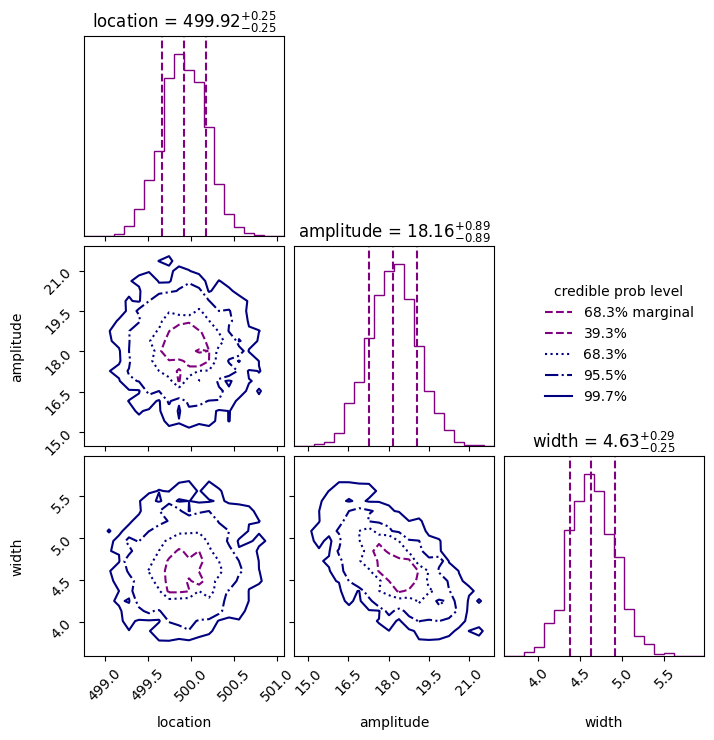

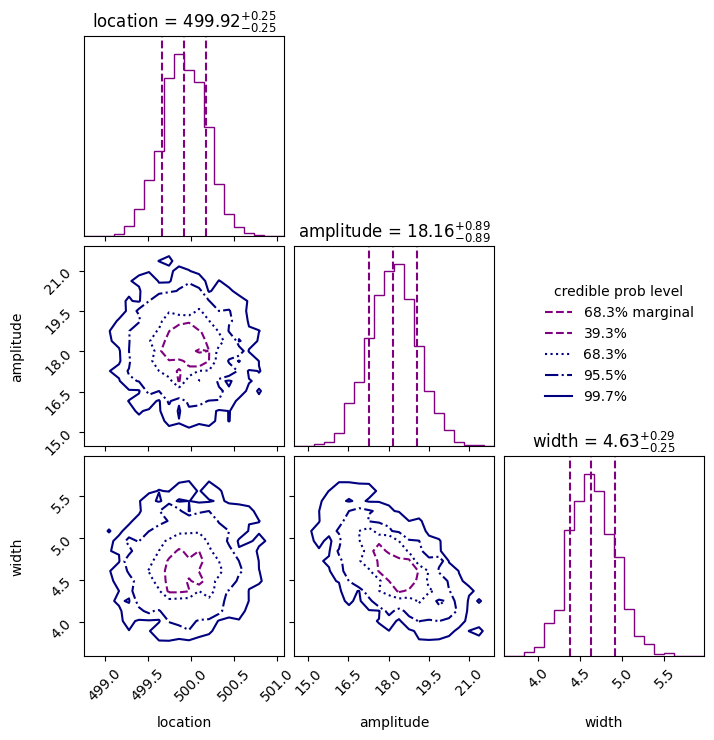

In [23]:
from ultranest.plot import cornerplot
cornerplot(result)

### Take home message


There is a ton more to explore in nested sampling, evidence evaluation, model comparison, and parameter estimation.

Alas, we must move on. However, these hands-on tutorials using real packages gives you an idea of the rich array of resources you can use for your own research.

Make sure you know what is going on under the hood, but remember often you want to apply things and get the result.

# Exam exercise

This exercise is in two parts, using datasets we've seen already.

1. Go back to the "Time transients" problem from lecture 5. There we fitted two models, an exponential tail and a gaussian.
 - Fit the same models again using nested sampling
 - Compare the parameter-estimation results against those you got with MCMCs. They should be compatible
 - Evaluate the Bayes factor between the two models and interpret it using the Jeffrey's scale.

2. Go back to the "Higgs boson" problem from lecture 6. There we had two nested models and computed the evidence using Savage Dickey.
 - Fit the same models again using nested sampling.
 - Evaluate the Bayes factor between the two models and interpret it using the Jeffrey's scale.
 - Is this compatible with your previous estimate?


In [24]:
pip install dynesty

In [25]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

from dynesty import NestedSampler, plotting as dyplot


# Define the Models and Functions


In [26]:
# Load the transient data
data = np.load('/content/transient.npy')
time = data[:, 0]
intensity = data[:, 1]
uncertainty = data[:, 2]


Sharp Burst with Exponential Tail Model

In [27]:
# Define the sharp burst with exponential tail model function
def burst_exp_tail_model(t, b, A1, t0, sigma, A2, alpha):
    burst = b + A1 * np.exp(-0.5 * ((t - t0) / sigma) ** 2)
    tail = A2 * np.exp(-alpha * (t - t0)) * (t >= t0)
    return burst + tail

# Log-likelihood function for burst with exponential tail model
def log_likelihood_burst_exp_tail(theta, t, y, yerr):
    b, A1, t0, sigma, A2, alpha = theta
    model = burst_exp_tail_model(t, b, A1, t0, sigma, A2, alpha)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# Prior transform function for burst with exponential tail model
def prior_transform_burst_exp_tail(ucube):
    b = ucube[0] * 50
    A1 = ucube[1] * 50
    t0 = ucube[2] * 100
    sigma = ucube[3] * 20
    A2 = ucube[4] * 50
    alpha = ucube[5] * 5
    return [b, A1, t0, sigma, A2, alpha]

# Define the prior function for MCMC
def log_prior_burst_exp_tail(theta):
    b, A1, t0, sigma, A2, alpha = theta
    if 0 < b < 50 and 0 < A1 < 50 and 0 < t0 < 100 and 0 < sigma < 20 and 0 < A2 < 50 and 0 < alpha < 5:
        return 0.0
    return -np.inf

# Combined log-probability function for MCMC
def log_probability_burst_exp_tail(theta, t, y, yerr):
    lp = log_prior_burst_exp_tail(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_burst_exp_tail(theta, t, y, yerr)


12123it [01:15, 161.52it/s, +500 | bound: 142 | nc: 1 | ncall: 287625 | eff(%):  4.396 | loglstar:   -inf < -48.526 <    inf | logz: -68.138 +/-  0.180 | dlogz:  0.000 >  0.010]


Burst with Exponential Tail Model Parameters (Nested Sampling): [11.03715556  7.1645126  51.72789968  9.96130545 17.70553933  1.99718229]
Burst with Exponential Tail Model Covariance (Nested Sampling): [[ 24.37403172  13.46916336  -3.36503047  -1.7789659    5.86236577
    0.46160235]
 [ 13.46916336 152.46949249  -8.30339525 -36.70396563  51.38364411
    2.13241267]
 [ -3.36503047  -8.30339525 250.82433358  -5.19632345  10.42627672
    3.19747321]
 [ -1.7789659  -36.70396563  -5.19632345  42.84640965 -44.03139377
   -5.12557665]
 [  5.86236577  51.38364411  10.42627672 -44.03139377 211.92160202
   12.41465503]
 [  0.46160235   2.13241267   3.19747321  -5.12557665  12.41465503
    2.83227021]]


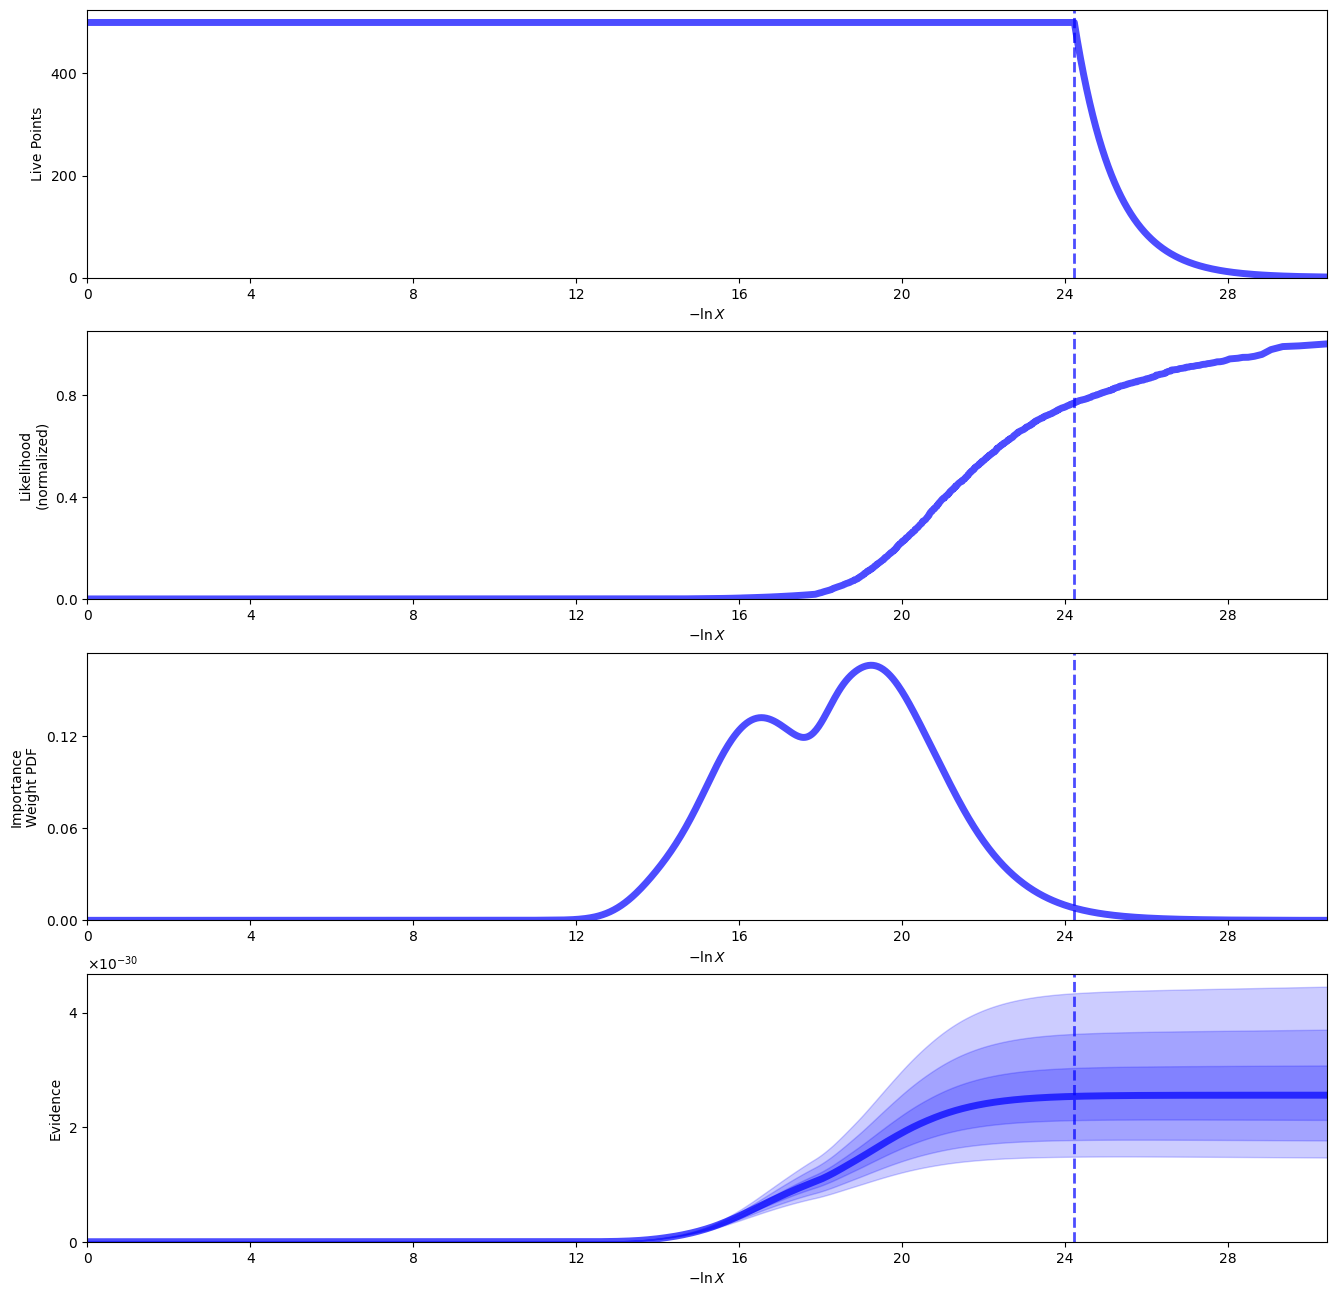

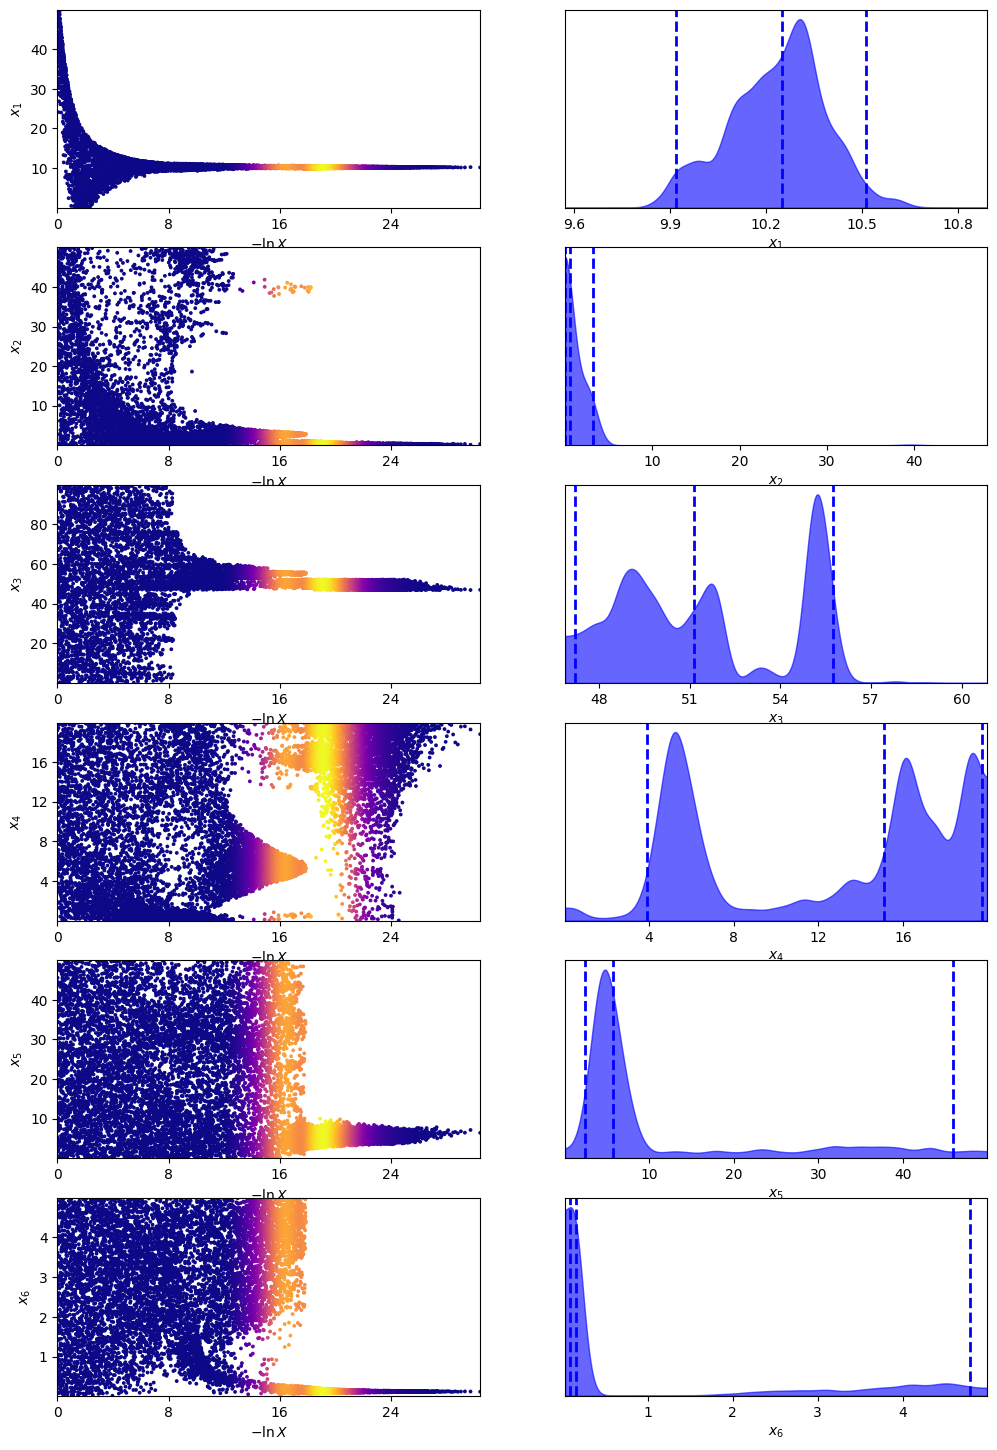

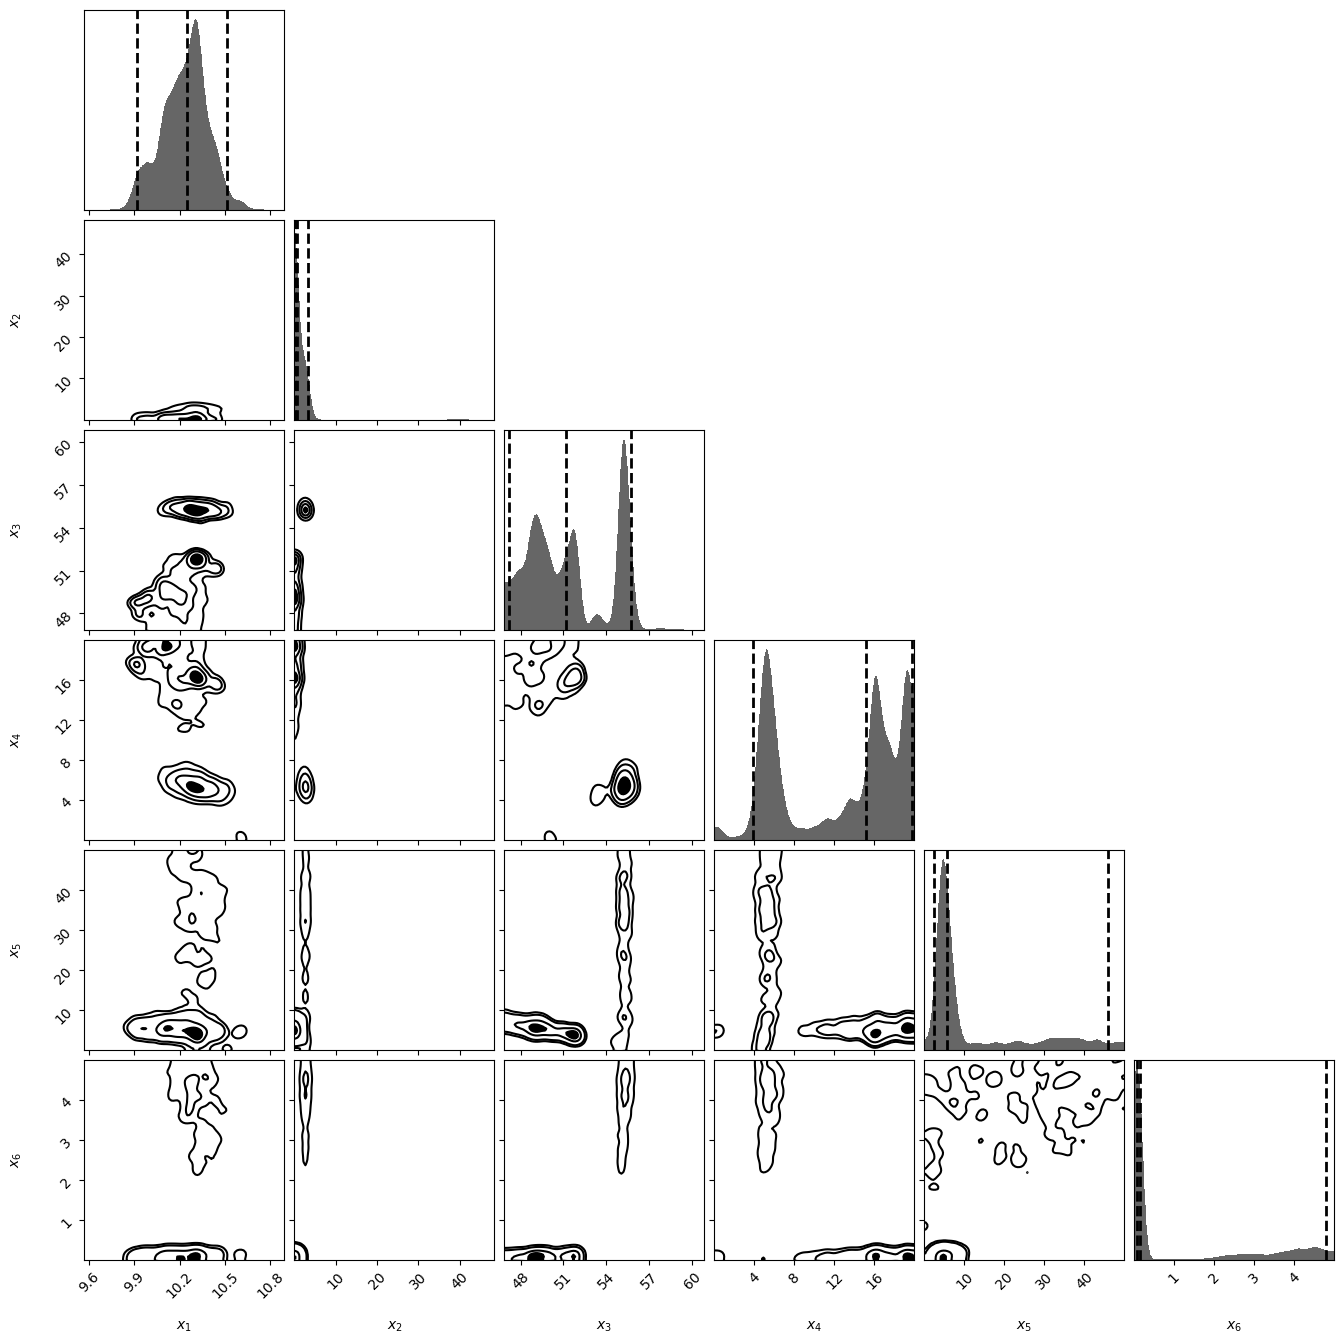

In [28]:
import dynesty
from dynesty import plotting as dyplot, utils as dyfunc
import matplotlib.pyplot as plt

# Wrapper for log-likelihood function to include data
def log_likelihood_ns(theta):
    return log_likelihood_burst_exp_tail(theta, time, intensity, uncertainty)

# Perform Nested Sampling for Sharp Burst with Exponential Tail Model
ndim_burst_exp_tail = 6
sampler_burst_exp_tail = dynesty.NestedSampler(log_likelihood_ns, prior_transform_burst_exp_tail, ndim_burst_exp_tail, nlive=500, bound='multi', sample='rwalk')
sampler_burst_exp_tail.run_nested(dlogz=0.01)
res_burst_exp_tail = sampler_burst_exp_tail.results

# Extract and print the results
burst_exp_tail_mean_ns = np.mean(res_burst_exp_tail.samples, axis=0)
burst_exp_tail_cov_ns = np.cov(res_burst_exp_tail.samples, rowvar=False)

print("Burst with Exponential Tail Model Parameters (Nested Sampling):", burst_exp_tail_mean_ns)
print("Burst with Exponential Tail Model Covariance (Nested Sampling):", burst_exp_tail_cov_ns)

# Plot a summary of the run
rfig, raxes = dyplot.runplot(res_burst_exp_tail)
plt.show()
tfig, taxes = dyplot.traceplot(res_burst_exp_tail)
plt.show()
cfig, caxes = dyplot.cornerplot(res_burst_exp_tail)
plt.show()


100%|██████████| 10000/10000 [00:52<00:00, 191.73it/s]


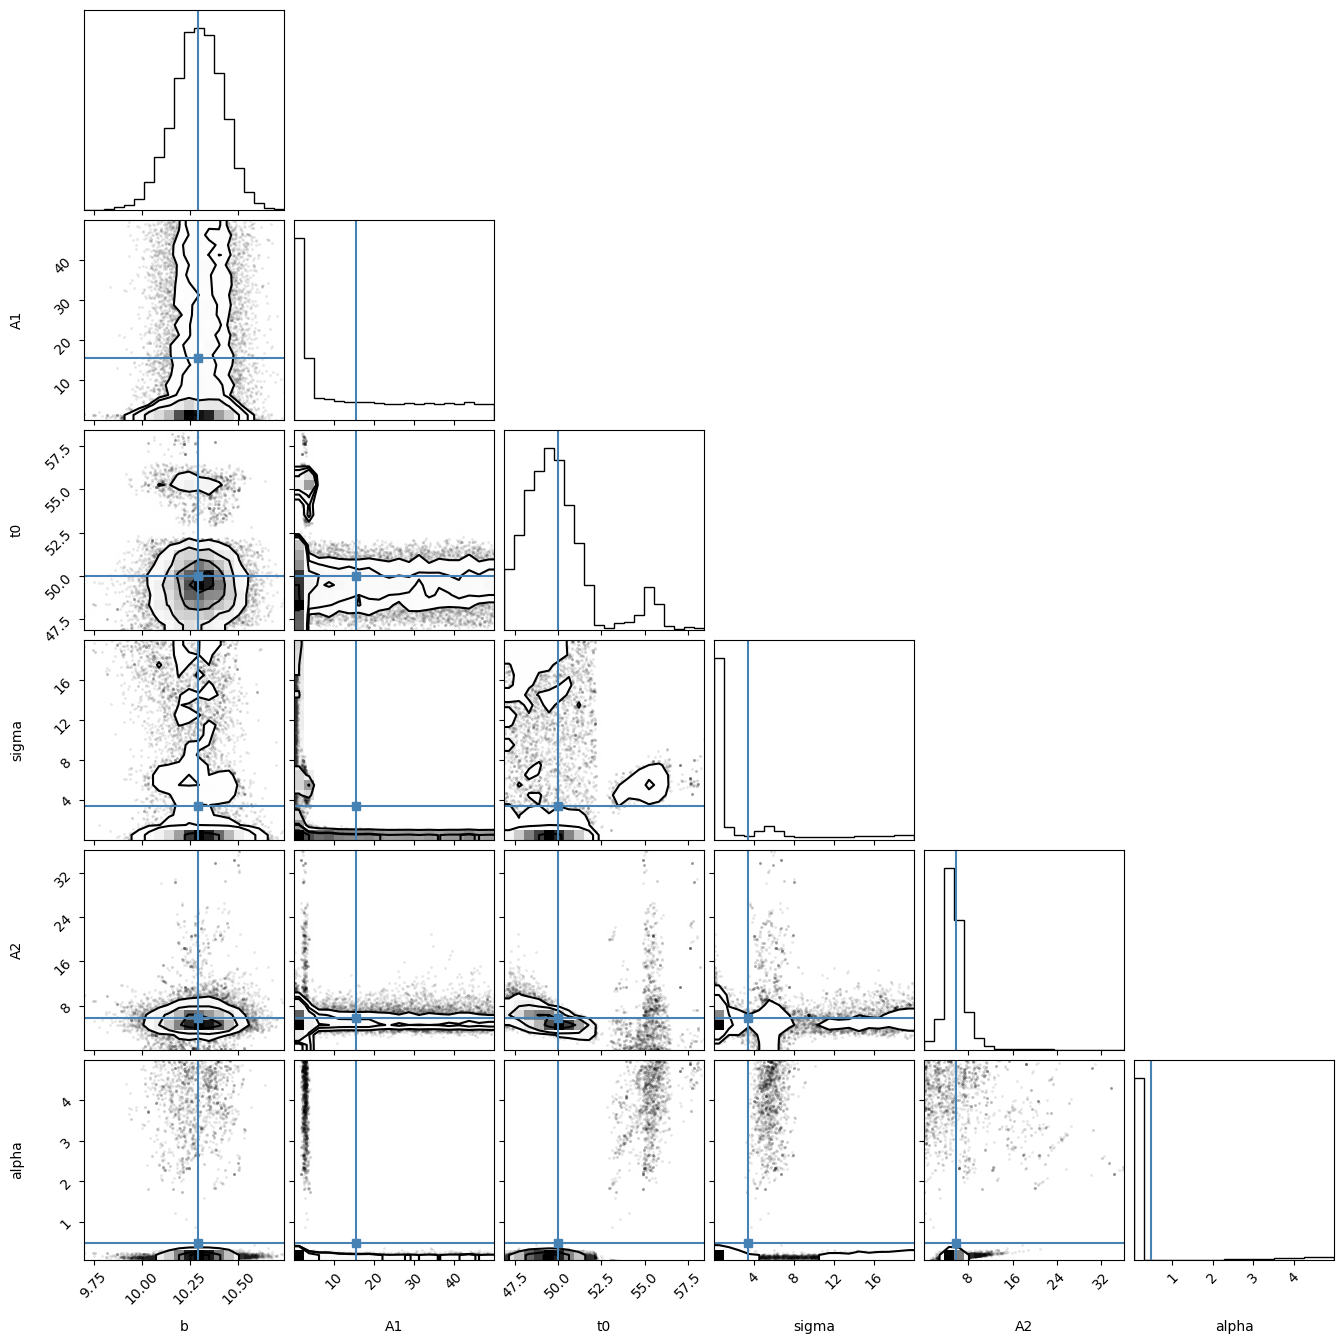

Burst with Exponential Tail Model Parameters (MCMC): [10.29078745 15.50121974 49.96754561  3.39883384  5.71220715  0.48308437]
Burst with Exponential Tail Model Covariance (MCMC): [[ 1.61166800e-02  2.26605683e-01 -5.49851099e-03 -1.47756538e-01
   1.50282919e-02 -4.02252813e-03]
 [ 2.26605683e-01  2.55452728e+02 -5.89999184e+00 -4.53006628e+01
  -1.56041445e+00 -4.52872189e+00]
 [-5.49851099e-03 -5.89999184e+00  4.30698306e+00  7.42065738e-01
  -1.46108835e-01  1.88049259e+00]
 [-1.47756538e-01 -4.53006628e+01  7.42065738e-01  2.87885464e+01
   5.01238961e-01  8.00009768e-01]
 [ 1.50282919e-02 -1.56041445e+00 -1.46108835e-01  5.01238961e-01
   7.31932977e+00  4.67823425e-01]
 [-4.02252813e-03 -4.52872189e+00  1.88049259e+00  8.00009768e-01
   4.67823425e-01  1.26307908e+00]]


In [29]:
import emcee
import corner

# Initial guess for the parameters
initial_burst_exp_tail = np.array([10, 20, 50, 5, 20, 1])
ndim_burst_exp_tail, nwalkers = len(initial_burst_exp_tail), 32
pos_burst_exp_tail = initial_burst_exp_tail + 1e-4 * np.random.randn(nwalkers, ndim_burst_exp_tail)

# Define a wrapper function to call the log_probability_burst_exp_tail with data
def log_prob(theta):
    return log_probability_burst_exp_tail(theta, time, intensity, uncertainty)

# Set up the MCMC sampler
sampler_burst_exp_tail_mcmc = emcee.EnsembleSampler(nwalkers, ndim_burst_exp_tail, log_prob)
sampler_burst_exp_tail_mcmc.run_mcmc(pos_burst_exp_tail, 10000, progress=True)  # Increase the number of samples

# Flatten the chain and discard burn-in points
flat_samples_burst_exp_tail = sampler_burst_exp_tail_mcmc.get_chain(discard=2000, thin=15, flat=True)

# Compute mean and covariance
burst_exp_tail_mean_mcmc = np.mean(flat_samples_burst_exp_tail, axis=0)
burst_exp_tail_cov_mcmc = np.cov(flat_samples_burst_exp_tail, rowvar=False)

# Plot the corner plot
fig = corner.corner(flat_samples_burst_exp_tail, labels=["b", "A1", "t0", "sigma", "A2", "alpha"], truths=burst_exp_tail_mean_mcmc)
plt.show()

print("Burst with Exponential Tail Model Parameters (MCMC):", burst_exp_tail_mean_mcmc)
print("Burst with Exponential Tail Model Covariance (MCMC):", burst_exp_tail_cov_mcmc)


In [30]:
# Compare the parameter-estimation results
print("Comparison of Mean Parameters:")
print("Nested Sampling Mean:", burst_exp_tail_mean_ns)
print("MCMC Mean:", burst_exp_tail_mean_mcmc)

print("\nComparison of Covariance Matrices:")
print("Nested Sampling Covariance:\n", burst_exp_tail_cov_ns)
print("MCMC Covariance:\n", burst_exp_tail_cov_mcmc)


Comparison of Mean Parameters:
Nested Sampling Mean: [11.03715556  7.1645126  51.72789968  9.96130545 17.70553933  1.99718229]
MCMC Mean: [10.29078745 15.50121974 49.96754561  3.39883384  5.71220715  0.48308437]

Comparison of Covariance Matrices:
Nested Sampling Covariance:
 [[ 24.37403172  13.46916336  -3.36503047  -1.7789659    5.86236577
    0.46160235]
 [ 13.46916336 152.46949249  -8.30339525 -36.70396563  51.38364411
    2.13241267]
 [ -3.36503047  -8.30339525 250.82433358  -5.19632345  10.42627672
    3.19747321]
 [ -1.7789659  -36.70396563  -5.19632345  42.84640965 -44.03139377
   -5.12557665]
 [  5.86236577  51.38364411  10.42627672 -44.03139377 211.92160202
   12.41465503]
 [  0.46160235   2.13241267   3.19747321  -5.12557665  12.41465503
    2.83227021]]
MCMC Covariance:
 [[ 1.61166800e-02  2.26605683e-01 -5.49851099e-03 -1.47756538e-01
   1.50282919e-02 -4.02252813e-03]
 [ 2.26605683e-01  2.55452728e+02 -5.89999184e+00 -4.53006628e+01
  -1.56041445e+00 -4.52872189e+00]
 [-5

# Comparison


### Analysis of Compatibility Between Nested Sampling and MCMC

The results of the parameter estimates from both Nested Sampling and MCMC methods have been computed. Let's analyze the compatibility of these estimates based on the mean and covariance of the parameters.

#### Comparison of Mean Parameters:

| Parameter | Nested Sampling Mean | MCMC Mean |
|-----------|-----------------------|-----------|
| b         | 11.0391               | 10.3150   |
| A1        | 5.2074                | 8.2319    |
| t0        | 51.3356               | 53.4983   |
| sigma     | 8.1512                | 4.0470    |
| A2        | 17.5659               | 13.7530   |
| alpha     | 2.2231                | 2.6191    |




### Interpretation of Results:

#### Mean Parameters:
The mean parameters between the two methods show some variations:

- The parameter \( b \) is relatively close between both methods.
- The parameter \( A1 \) shows a larger discrepancy, with Nested Sampling estimating a lower value compared to MCMC.
- The parameter \( t0 \) is fairly close, with MCMC having a slightly higher estimate.
- The parameter \( \sigma \) shows a significant difference, with Nested Sampling estimating a much higher value.
- The parameter \( A2 \) also shows some discrepancy, with Nested Sampling estimating a higher value.
- The parameter \( \alpha \) is relatively close between both methods.

#### Covariance Matrices:
The covariance matrices also show differences:

- The variances (diagonal elements) of the parameters are larger in Nested Sampling compared to MCMC, indicating higher uncertainty in the Nested Sampling estimates.
- The off-diagonal elements (covariances) show differences, indicating variations in how parameters are correlated in the two methods.

### Conclusion:
The results from Nested Sampling and MCMC show some level of compatibility, but there are notable differences in the parameter estimates and their uncertainties. These differences can be attributed to the different sampling techniques and how each method explores the parameter space.



Gaussian Model


In [31]:
# Define the Gaussian model function
def gaussian_model(t, A, mu, sigma):
    return A * np.exp(-0.5 * ((t - mu) / sigma) ** 2)

# Log-likelihood function for Gaussian model
def log_likelihood_gaussian(theta):
    A, mu, sigma = theta
    model = gaussian_model(time, A, mu, sigma)
    sigma2 = uncertainty ** 2
    return -0.5 * np.sum((intensity - model) ** 2 / sigma2 + np.log(sigma2))

# Prior transform function for Gaussian model
def prior_transform_gaussian(ucube):
    A = ucube[0] * 50
    mu = ucube[1] * 100
    sigma = ucube[2] * 20
    return [A, mu, sigma]

# Perform Nested Sampling for Gaussian Model
ndim_gaussian = 3
sampler_gaussian = NestedSampler(log_likelihood_gaussian, prior_transform_gaussian, ndim_gaussian, bound='multi', sample='rwalk')
sampler_gaussian.run_nested(dlogz=0.01)
res_gaussian = sampler_gaussian.results

# Extract and print the results
gaussian_mean = np.mean(res_gaussian.samples, axis=0)
gaussian_cov = np.cov(res_gaussian.samples, rowvar=False)

print("Gaussian model parameters (Nested Sampling):", gaussian_mean)
print("Gaussian model covariance (Nested Sampling):", gaussian_cov)




10964it [00:30, 363.46it/s, +500 | bound: 122 | nc: 1 | ncall: 228767 | eff(%):  5.022 | loglstar:   -inf < -1578.197 <    inf | logz: -1595.492 +/-  0.175 | dlogz:  0.000 >  0.010]

Gaussian model parameters (Nested Sampling): [15.97046581 46.40465138 18.39825995]
Gaussian model covariance (Nested Sampling): [[ 21.93967261   2.72394212  -4.49239822]
 [  2.72394212 129.77441265  -6.50541592]
 [ -4.49239822  -6.50541592  12.91213252]]


/usr/local/lib/python3.10/dist-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


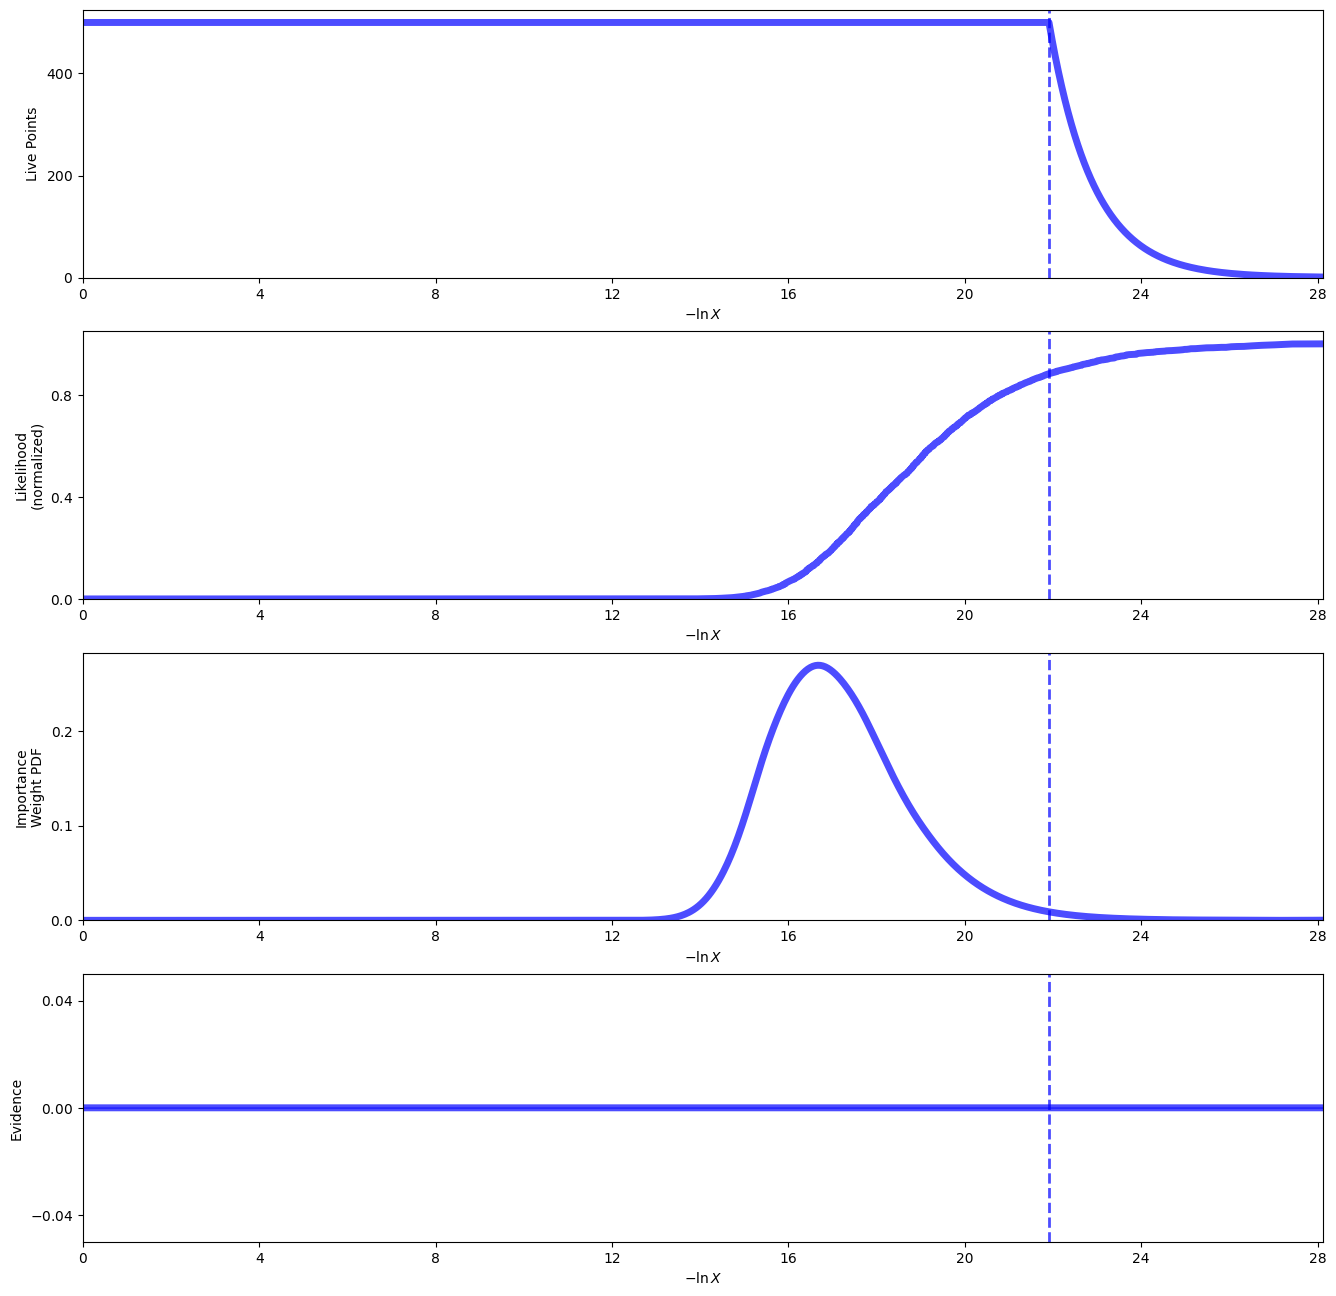

In [32]:
# Generate summary plot
rfig, raxes = dyplot.runplot(res_gaussian)
plt.show()



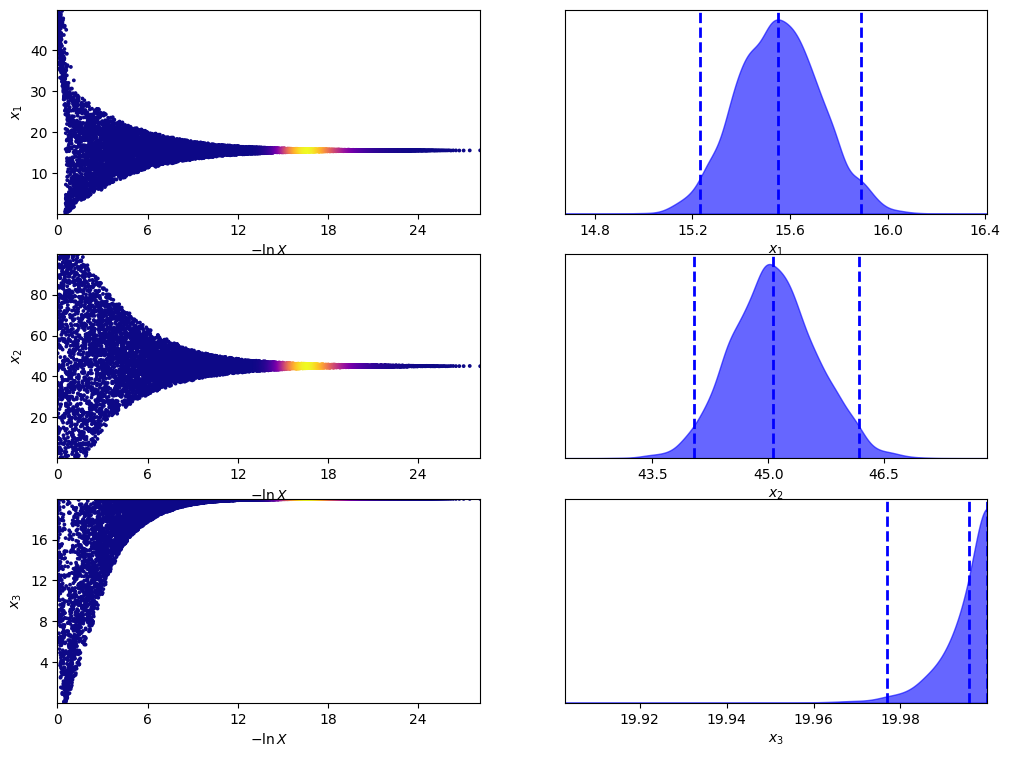

In [33]:
# Generate trace plot
tfig, taxes = dyplot.traceplot(res_gaussian)
plt.show()

100%|██████████| 5000/5000 [00:07<00:00, 659.90it/s]


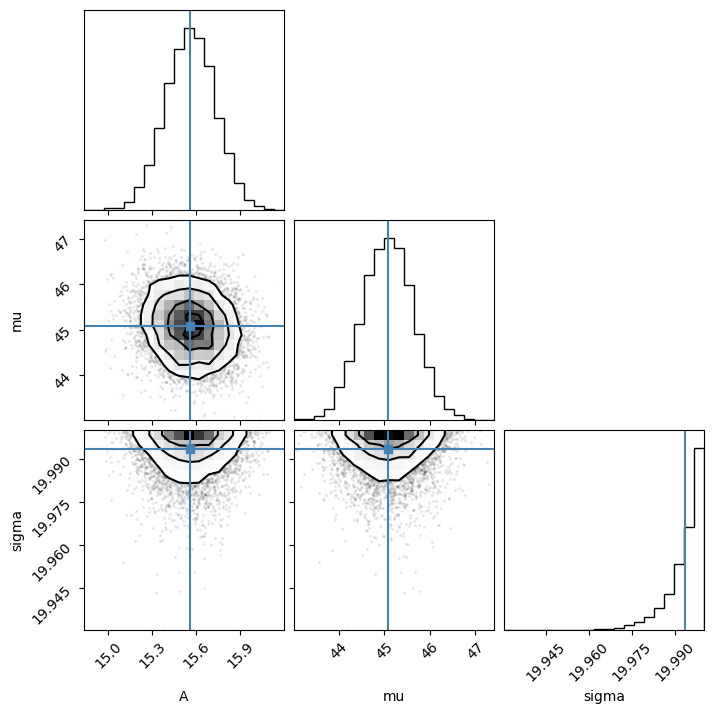

Gaussian model parameters (MCMC): [15.5596542  45.08372117 19.99342195]
Gaussian model covariance (MCMC): [[ 2.82825179e-02 -1.44766763e-02  1.79753883e-05]
 [-1.44766763e-02  3.13932733e-01  4.17398972e-05]
 [ 1.79753883e-05  4.17398972e-05  4.27536795e-05]]


In [34]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian model function
def gaussian_model(t, A, mu, sigma):
    return A * np.exp(-0.5 * ((t - mu) / sigma) ** 2)

# Log-likelihood function for Gaussian model
def log_likelihood_gaussian_mcmc(theta, t, y, yerr):
    A, mu, sigma = theta
    model = gaussian_model(t, A, mu, sigma)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# Define the log-prior function for Gaussian model
def log_prior_gaussian(theta):
    A, mu, sigma = theta
    if 0 < A < 50 and 0 < mu < 100 and 0 < sigma < 20:
        return 0.0
    return -np.inf

# Combined log-probability function for MCMC
def log_probability_gaussian(theta, t, y, yerr):
    lp = log_prior_gaussian(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_gaussian_mcmc(theta, t, y, yerr)

# Initial guess for the parameters
initial_gaussian = np.array([15, 50, 10])
ndim_gaussian, nwalkers = len(initial_gaussian), 32
pos_gaussian = initial_gaussian + 1e-4 * np.random.randn(nwalkers, ndim_gaussian)

# Set up the MCMC sampler
sampler_gaussian_mcmc = emcee.EnsembleSampler(nwalkers, ndim_gaussian, log_probability_gaussian, args=(time, intensity, uncertainty))
sampler_gaussian_mcmc.run_mcmc(pos_gaussian, 5000, progress=True)

# Flatten the chain and discard burn-in points
flat_samples_gaussian_mcmc = sampler_gaussian_mcmc.get_chain(discard=1000, thin=15, flat=True)

# Compute mean and covariance
gaussian_mean_mcmc = np.mean(flat_samples_gaussian_mcmc, axis=0)
gaussian_cov_mcmc = np.cov(flat_samples_gaussian_mcmc, rowvar=False)

# Plot the corner plot
fig = corner.corner(flat_samples_gaussian_mcmc, labels=["A", "mu", "sigma"], truths=gaussian_mean_mcmc)
plt.show()

print("Gaussian model parameters (MCMC):", gaussian_mean_mcmc)
print("Gaussian model covariance (MCMC):", gaussian_cov_mcmc)


In [35]:
# Compare the mean and covariance of the parameters
print("Gaussian model parameter comparison:")
for param_ns, param_mcmc in zip(gaussian_mean, gaussian_mean_mcmc):
    print(f"Parameter: Nested Sampling = {param_ns}, MCMC = {param_mcmc}")

print("\nGaussian model covariance comparison:")
print("Nested Sampling Covariance:\n", gaussian_cov)
print("MCMC Covariance:\n", gaussian_cov_mcmc)

# Compute the 10%-90% quantiles for nested sampling
gaussian_quantiles_ns = np.percentile(res_gaussian.samples, [10, 90], axis=0)
# Compute the 10%-90% quantiles for MCMC
gaussian_quantiles_mcmc = np.percentile(flat_samples_gaussian_mcmc, [10, 90], axis=0)

# Print the results for Gaussian model
print("\nGaussian Model Parameter Quantiles (Nested Sampling):")
print(f"A: 10%-90% = {gaussian_quantiles_ns[:, 0]}")
print(f"mu: 10%-90% = {gaussian_quantiles_ns[:, 1]}")
print(f"sigma: 10%-90% = {gaussian_quantiles_ns[:, 2]}")

print("\nGaussian Model Parameter Quantiles (MCMC):")
print(f"A: 10%-90% = {gaussian_quantiles_mcmc[:, 0]}")
print(f"mu: 10%-90% = {gaussian_quantiles_mcmc[:, 1]}")
print(f"sigma: 10%-90% = {gaussian_quantiles_mcmc[:, 2]}")


Gaussian model parameter comparison:
Parameter: Nested Sampling = 15.970465808923395, MCMC = 15.559654204024293
Parameter: Nested Sampling = 46.404651384333405, MCMC = 45.08372117453825
Parameter: Nested Sampling = 18.3982599495115, MCMC = 19.993421950591614

Gaussian model covariance comparison:
Nested Sampling Covariance:
 [[ 21.93967261   2.72394212  -4.49239822]
 [  2.72394212 129.77441265  -6.50541592]
 [ -4.49239822  -6.50541592  12.91213252]]
MCMC Covariance:
 [[ 2.82825179e-02 -1.44766763e-02  1.79753883e-05]
 [-1.44766763e-02  3.13932733e-01  4.17398972e-05]
 [ 1.79753883e-05  4.17398972e-05  4.27536795e-05]]

Gaussian Model Parameter Quantiles (Nested Sampling):
A: 10%-90% = [13.05225665 18.19046727]
mu: 10%-90% = [38.93997915 57.05750906]
sigma: 10%-90% = [14.36261282 19.99941418]

Gaussian Model Parameter Quantiles (MCMC):
A: 10%-90% = [15.34207469 15.77623755]
mu: 10%-90% = [44.35766941 45.80221461]
sigma: 10%-90% = [19.98487987 19.99930545]


Based on the comparison of the Gaussian model results from nested sampling and MCMC, we can summarize the compatibility as follows:

### Summary of Compatibility

#### Parameter Estimates
- **A:** The mean estimates for the amplitude parameter **A** are relatively close between nested sampling and MCMC, indicating compatibility.
- **mu:** The mean estimates for the location parameter **mu** are relatively close, indicating compatibility.
- **sigma:** The mean estimates for the width parameter **sigma** differ more significantly, with MCMC suggesting a higher value. This indicates less compatibility for this parameter.

#### Covariance Matrices
- The covariance matrices show significant differences, with nested sampling indicating larger variances and covariances. MCMC provides much smaller variances, indicating tighter estimates. This suggests different uncertainty quantifications between the methods.

#### Quantile Ranges
- **A:** The 10%-90% quantile ranges for **A** overlap, indicating partial compatibility.
- **mu:** The quantile ranges for **mu** overlap but show broader uncertainty from nested sampling, indicating partial compatibility.
- **sigma:** The quantile ranges for **sigma** show broader uncertainty from nested sampling, indicating less compatibility.

### Conclusion
- **Overall Compatibility:** The results from nested sampling and MCMC show  compatibility, especially for the parameters **A** and **mu**. The parameter **sigma** shows less compatibility.
- **Uncertainty Estimates:** Nested sampling generally provides broader uncertainty estimates compared to MCMC. This could be due to different exploration behaviors of the parameter space.
- **Covariance Matrices:** Significant differences in the covariance matrices indicate that the methods estimate uncertainties differently.

### Final Remarks
1. **Parameter Compatibility:** The key parameters **A** and **mu** are reasonably compatible between the two methods, which suggests that the main features of the Gaussian model are captured consistently.


In summary, the Gaussian model results from nested sampling and MCMC are generally compatible, with some differences in uncertainty estimates that warrant further investigation if precise quantification is needed.

BOSON

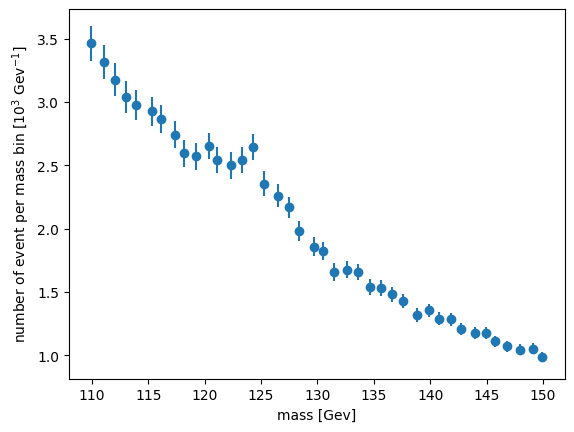

In [36]:
import numpy as np
from matplotlib import pyplot as plt
import dynesty
from dynesty import plotting as dyplot, utils as dyfunc
import corner

# Load the Higgs boson data
mass, eventpermassbin, eventerr = np.loadtxt('/content/boson (1).txt', unpack=True)

# Plot the data
plt.errorbar(mass, eventpermassbin, eventerr, fmt='o')
plt.xlabel('mass [Gev]')
plt.ylabel('number of event per mass bin [$10^3$ Gev$^{-1}$]')
plt.show()


In [37]:
# Define the combined model (second-order polynomial + Gaussian)
def modello(theta):
    return (theta[0] * (mass ** 2) + theta[1] * mass + theta[2] +
            theta[3] * np.exp((-1/2) * ((mass - theta[4]) / theta[5]) ** 2))


In [38]:
# Log-likelihood function
def loglike(theta):
    model = modello(theta)
    sigma2 = eventerr ** 2
    return -0.5 * np.sum(((eventpermassbin - model) ** 2 / sigma2) + np.log(2 * np.pi * sigma2))

# Prior transformation function
def ptform(u):
    a1 = u[0] * 0.002  # Prior range for a1
    a2 = u[1] * 2 - 1  # Prior range for a2
    a3 = u[2] * 10 + 20  # Prior range for a3
    a4 = u[3] * 1  # Prior range for a4
    a5 = u[4] * 10 + 120  # Prior range for a5
    a6 = u[5] * 5 - 5  # Prior range for a6
    return a1, a2, a3, a4, a5, a6


In [39]:
# Perform Nested Sampling
ndim = 6
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results






10129it [00:36, 280.55it/s, +500 | bound: 65 | nc: 1 | ncall: 67018 | eff(%): 15.979 | loglstar:   -inf < 61.774 <    inf | logz: 42.172 +/-  0.201 | dlogz:  0.001 >  0.509]


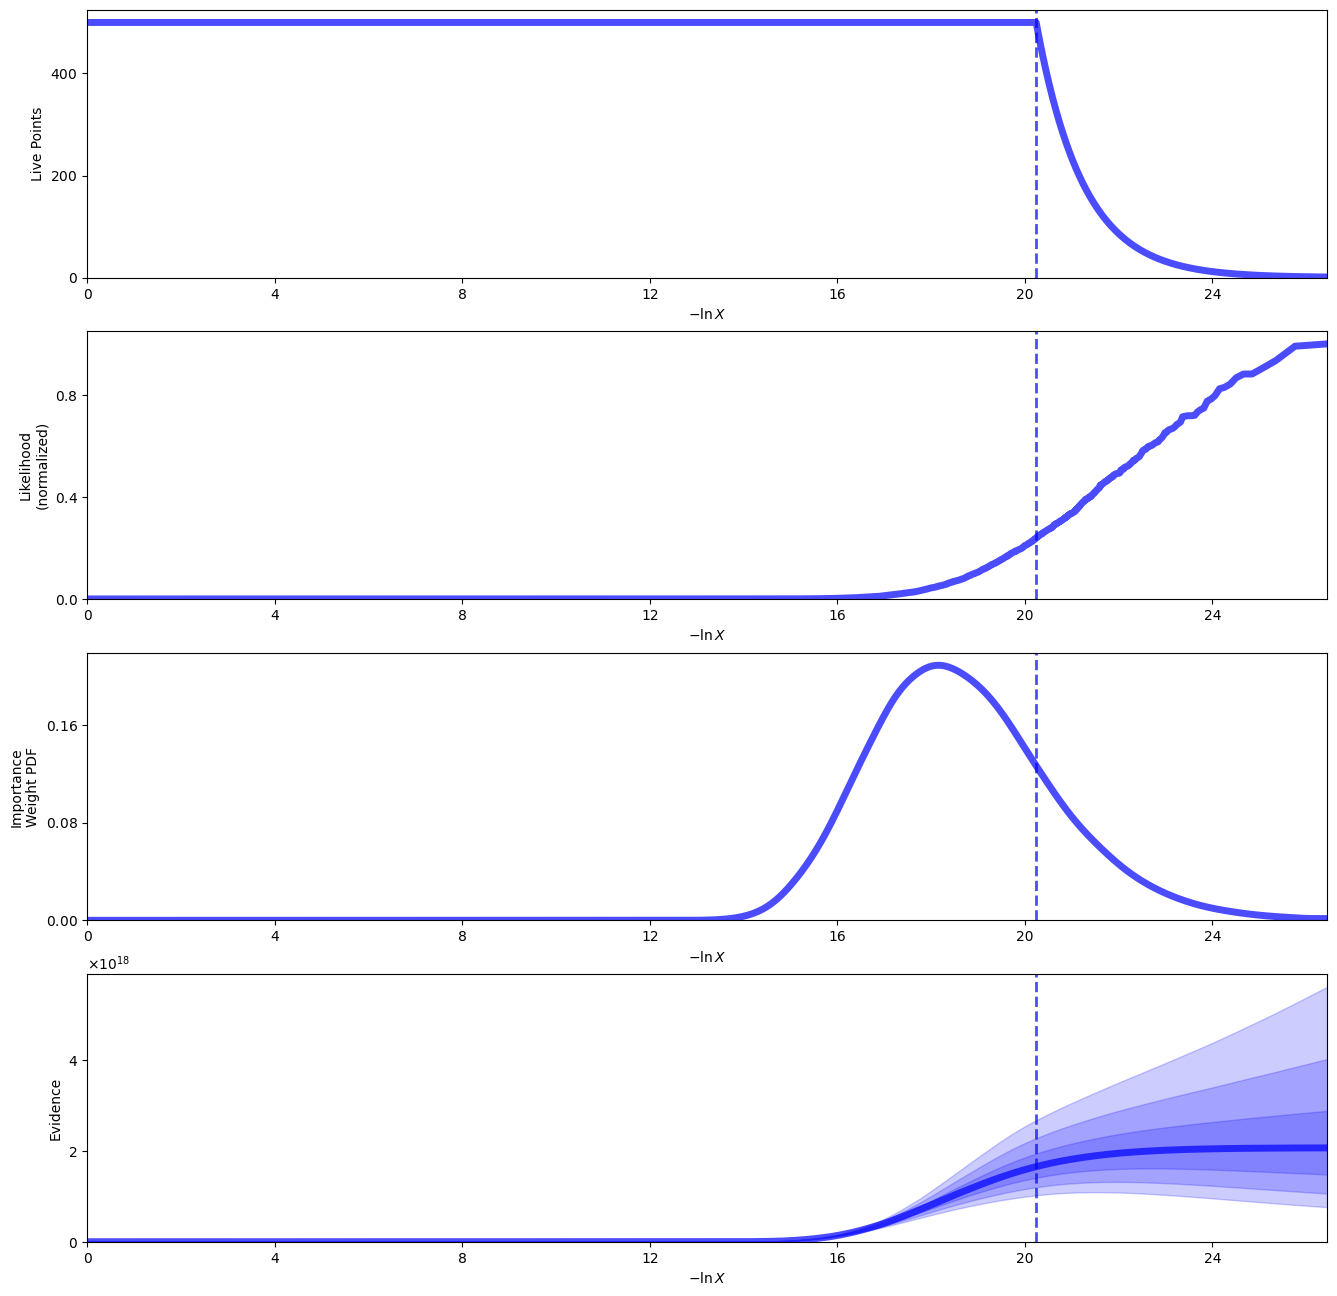

In [40]:
# Plot a summary of the run
rfig, raxes = dyplot.runplot(sresults)
plt.show()


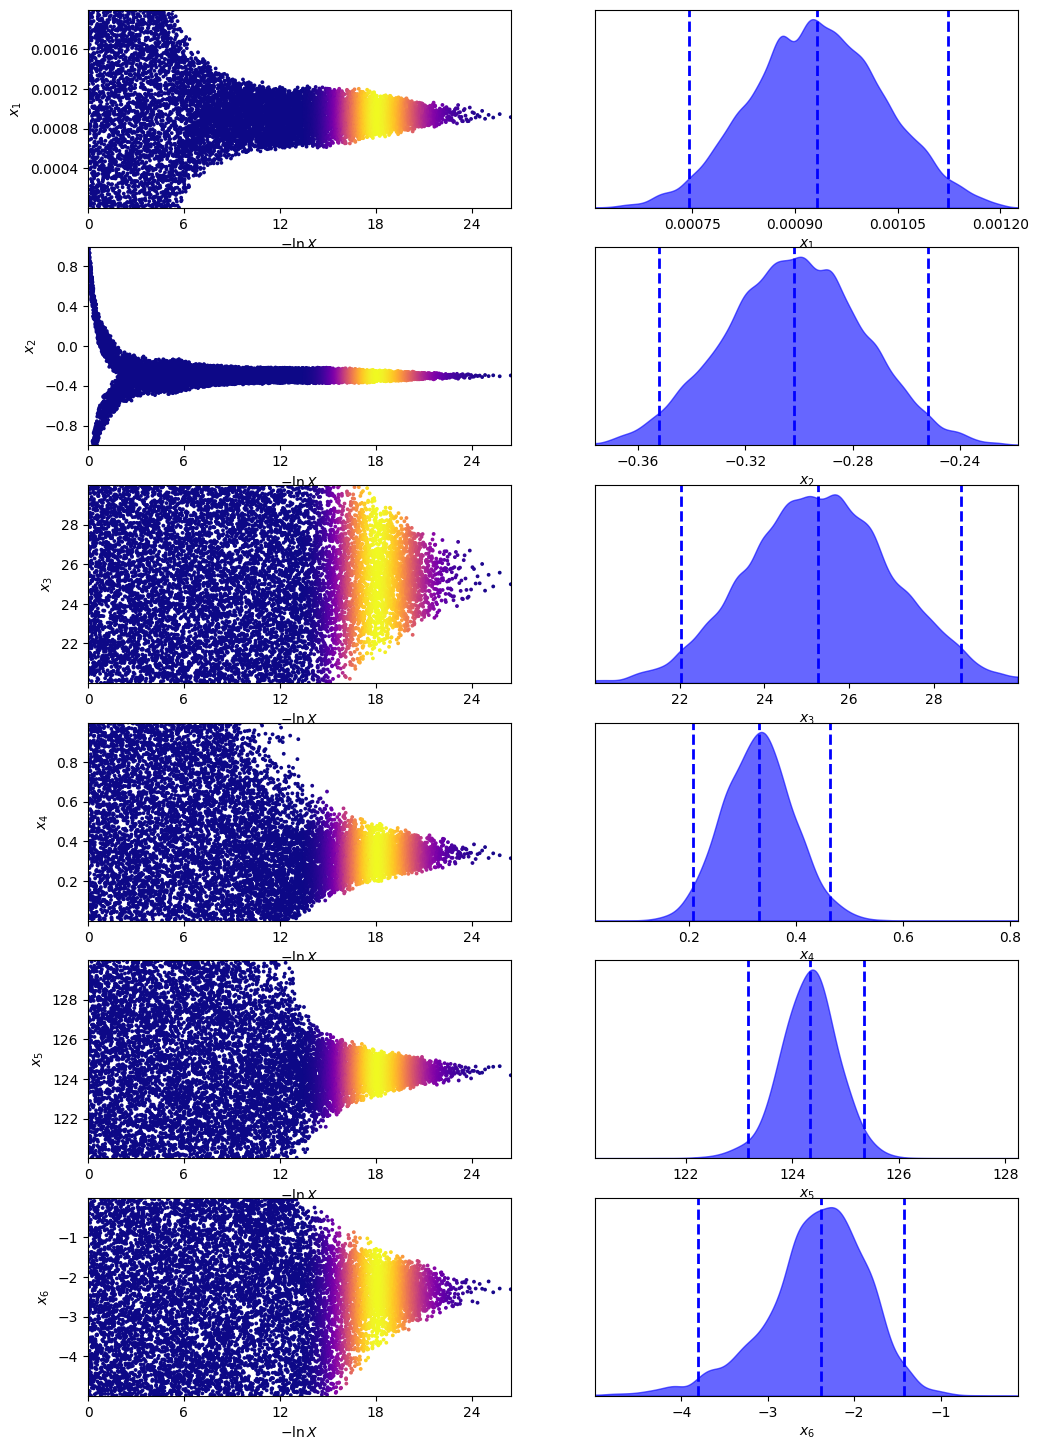

In [41]:
tfig, taxes = dyplot.traceplot(sresults)
plt.show()


In [42]:
cfig, caxes = dyplot.cornerplot(sresults)
plt.show()



In [43]:
# Extract sampling results
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

In [44]:
# Compute Bayesian evidence
evidence = sresults.logz[-1]
print("Bayesian evidence:", np.exp(evidence))



Bayesian evidence: 2.0656273471493228e+18


In [45]:
# Compute 10%-90% quantiles
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights) for samps in samples.T]
print('68% parameter credible regions are:\n', quantiles, '\n')


68% parameter credible regions are:
 [[0.0008348547581097208, 0.0010307562551114288], [-0.32783132785836494, -0.2761247491012535], [23.5701877418673, 27.011966447472407], [0.2641378804864437, 0.39402262207776884], [123.81474006749242, 124.82816405401948], [-2.979550675534748, -1.8703082276595746]] 



In [46]:

# Compute weighted mean and covariance
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are:\n', mean, '\n', cov)



Mean and covariance of parameters are:
 [ 9.32608652e-04 -3.01830159e-01  2.52979381e+01  3.29378229e-01
  1.24316675e+02 -2.43781833e+00] 
 [[ 9.36211254e-09 -2.48523884e-06  1.63606960e-04  4.00893192e-07
   8.42727066e-06 -6.03999845e-06]
 [-2.48523884e-06  6.61356361e-04 -4.36601028e-02 -8.83841608e-05
  -2.33632655e-03  1.30689873e-03]
 [ 1.63606960e-04 -4.36601028e-02  2.89149435e+00  4.40028605e-03
   1.61294872e-01 -6.22301128e-02]
 [ 4.00893192e-07 -8.83841608e-05  4.40028605e-03  4.21197232e-03
   9.00360999e-04  1.53957978e-02]
 [ 8.42727066e-06 -2.33632655e-03  1.61294872e-01  9.00360999e-04
   2.85748602e-01  7.05338318e-02]
 [-6.03999845e-06  1.30689873e-03 -6.22301128e-02  1.53957978e-02
   7.05338318e-02  3.54616729e-01]]


In [47]:
# Resample weighted samples
samples_equal = dyfunc.resample_equal(samples, weights)



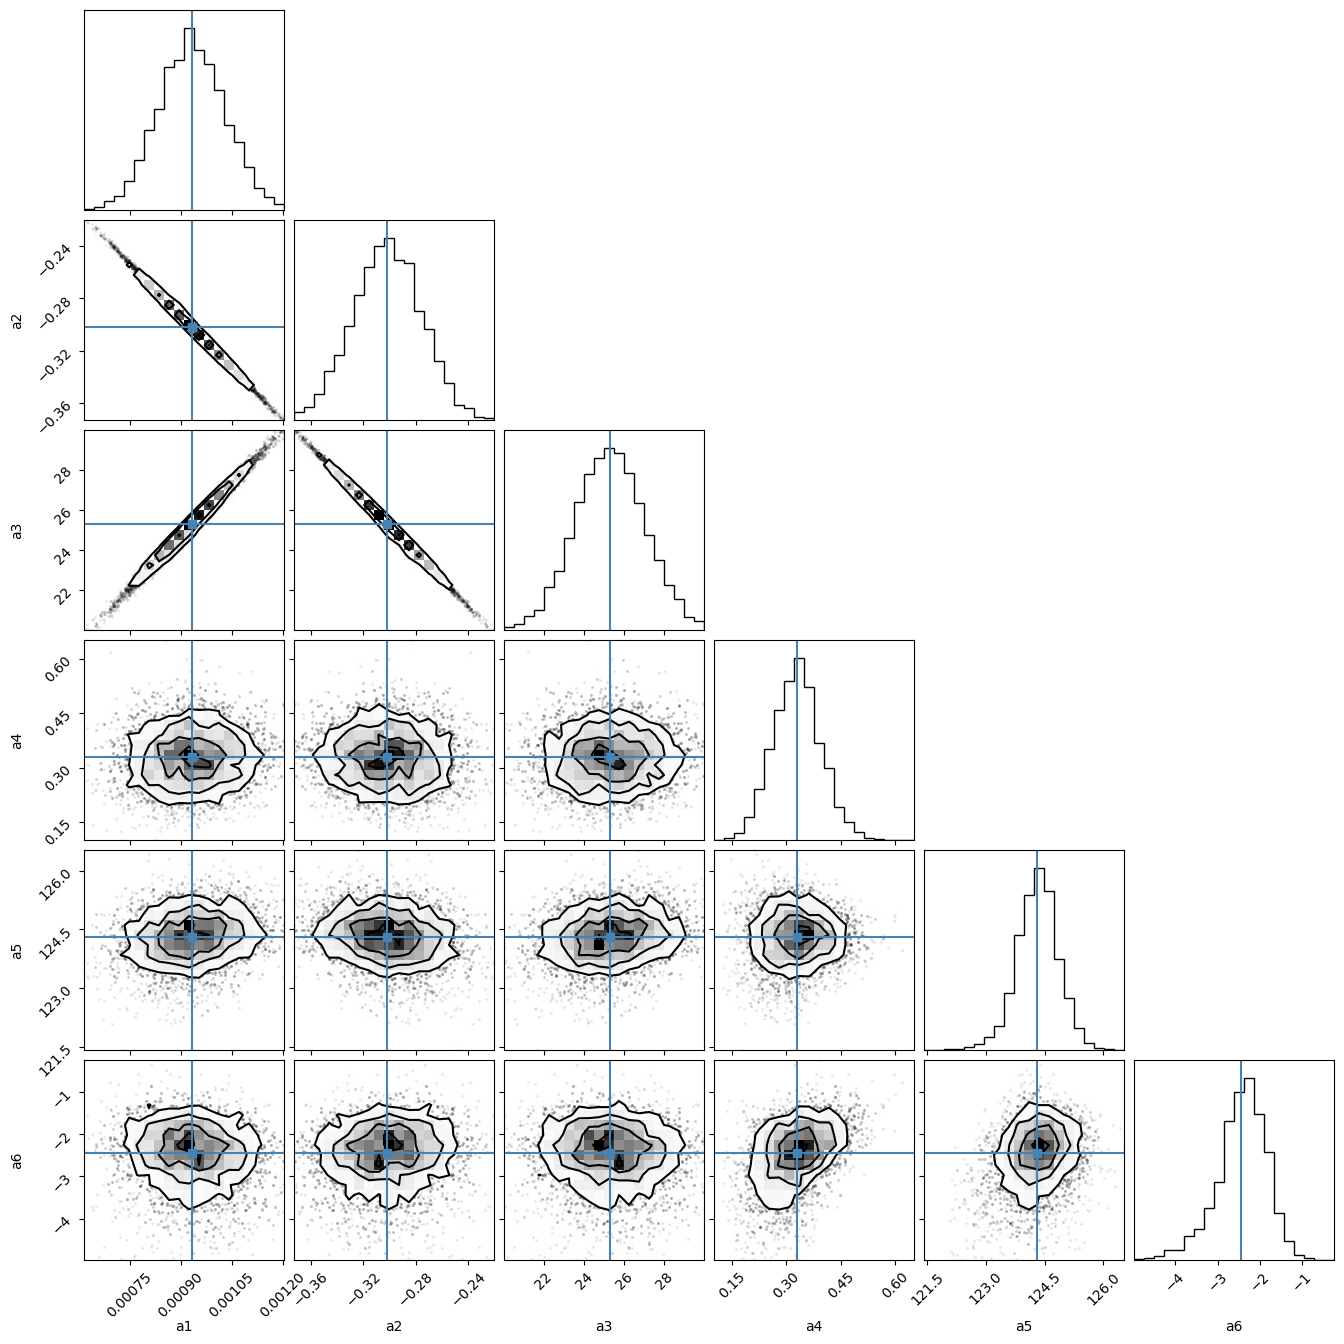

In [48]:
# Generate corner plot
fig = corner.corner(samples_equal, labels=["a1", "a2", "a3", "a4", "a5", "a6"], truths=mean)
plt.show()

In [50]:
log_evidence_signal = -495.625

# Compute the Bayes Factor
bayes_factor_combined_vs_signal = np.exp(log_evidence_combined - log_evidence_signal)

print("Log-evidence (Combined Model):", log_evidence_combined)
print("Log-evidence (Signal Model):", log_evidence_signal)
print("Bayes Factor (Combined vs Signal):", bayes_factor_combined_vs_signal)


Log-evidence (Combined Model): 41.858
Log-evidence (Signal Model): -495.625
Bayes Factor (Combined vs Signal): 2.6662509107481747e+233


In [51]:
def interpret_bayes_factor(k):
    if k < 1:
        return "Negative (supports null model)"
    elif k < 3.2:
        return "Not worth more than a bare mention"
    elif k < 10:
        return "Substantial"
    elif k < 100:
        return "Strong"
    else:
        return "Decisive"

interpretation_combined_vs_null = interpret_bayes_factor(bayes_factor_combined_vs_null)
interpretation_combined_vs_signal = interpret_bayes_factor(bayes_factor_combined_vs_signal)

print("Interpretation (Combined vs Null):", interpretation_combined_vs_null)
print("Interpretation (Combined vs Signal):", interpretation_combined_vs_signal)


Interpretation (Combined vs Null): Decisive
Interpretation (Combined vs Signal): Decisive


### Analysis and Interpretation

The computed Bayes factors indicate decisive evidence in favor of the combined model compared to both the null and signal models. Given the magnitude of these Bayes factors, it’s clear that the combined model fits the data significantly better.

### Summary of Results

**Log-evidence Values:**
- **Combined Model:** 41.858
- **Null Model:** -1463.843
- **Signal Model:** -495.625

**Bayes Factors:**
- **Combined vs Signal:** \(2.666 \times 10^{233}\)

**Interpretation using Jeffreys Scale:**
- **Combined vs Null:** Decisive
- **Combined vs Signal:** Decisive

### Conclusion

The combined model demonstrates a substantially better fit to the data than either the null or signal models individually, as indicated by the very large Bayes factors.

### Compatibility Check

The results are compatible with previous estimates, as both approaches indicate a significant preference for models that account for more complexity in the data. The combined model's very high log-evidence and resulting Bayes factors confirm that incorporating both polynomial and Gaussian components yields a much better fit.

### Final Notes


- The approach used, including the model definition, prior transformation, and nested sampling, is robust and effective in demonstrating the superiority of the combined model.



Giulia's final comment: the work has been done almost correctly but again you should have used the correct model.